# Improved Models Comparison

Comparison of improved V2 models with original models:
- Load original and improved models
- Evaluate on test set
- Create visualizations showing improvements
- Generate comparison report


In [33]:
#!pip install seaborn


In [34]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from tqdm import tqdm

# Determine project root (parent of notebooks directory)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name in ['notebooks', 'b-p_first_experiments'] else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

# Import original models
from models.hybrid.hybrid_cnn_mlp import HybridCNNMLP
from models.sequence.transformer_sequence import TransformerSequence
from models.specialized.formant_focused import FormantFocusedModel
from models.sequence.bilstm_attention import BiLSTMAttention

# Import improved models
from models.hybrid.hybrid_cnn_mlp_v2 import HybridCNNMLP_V2
from models.sequence.transformer_sequence_v2 import TransformerSequence_V2
from models.specialized.formant_focused_v2 import FormantFocusedModel_V2
from models.sequence.bilstm_attention_v2 import BiLSTMAttention_V2
from models.hybrid.hybrid_transformer_fusion import HybridTransformerFusion_V2

from utils.training_utils import evaluate_model
from utils.data_loader import load_data, create_dataloaders
from utils.ensemble_utils import get_model_predictions, weighted_voting

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using MPS device")
else:
    device = torch.device("cpu")

ORIGINAL_DIR = PROJECT_ROOT / 'artifacts' / 'b-p_dl_models'
IMPROVED_DIR = ORIGINAL_DIR / 'improved_models'
COMPARISON_DIR = IMPROVED_DIR / 'comparison'
COMPARISON_DIR.mkdir(parents=True, exist_ok=True)

# Load data
df, spectrograms_dict, feature_cols, feature_scaler, class_weights_dict = load_data(PROJECT_ROOT)
dataloaders = create_dataloaders(df, spectrograms_dict, feature_cols, feature_scaler, class_weights_dict, batch_size=64)

# Create fusion dataloader for HybridTransformerFusion_V2
from torch.utils.data import Dataset, DataLoader

class FusionDataset(Dataset):
    """Combines hybrid and sequence datasets"""
    def __init__(self, hybrid_dataset, sequence_dataset):
        assert len(hybrid_dataset) == len(sequence_dataset), "Datasets must have same length"
        self.hybrid_dataset = hybrid_dataset
        self.sequence_dataset = sequence_dataset
    
    def __len__(self):
        return len(self.hybrid_dataset)
    
    def __getitem__(self, idx):
        (spectrogram, features), label_hybrid = self.hybrid_dataset[idx]
        sequence, label_seq = self.sequence_dataset[idx]
        assert label_hybrid == label_seq, "Labels must match"
        return (spectrogram, features, sequence), label_hybrid

# Create fusion dataloaders
fusion_dataloaders = {}
for split in ['train', 'val', 'test']:
    fusion_ds = FusionDataset(dataloaders['hybrid'][split].dataset, dataloaders['sequence'][split].dataset)
    if split == 'train':
        fusion_dataloaders[split] = DataLoader(
            fusion_ds, 
            batch_size=64, 
            sampler=dataloaders['hybrid'][split].sampler,
            num_workers=0
        )
    else:
        fusion_dataloaders[split] = DataLoader(fusion_ds, batch_size=64, shuffle=False, num_workers=0)

dataloaders['fusion'] = fusion_dataloaders

class_weights = torch.tensor([class_weights_dict.get('0', class_weights_dict.get(0, 1.0)), 
                              class_weights_dict.get('1', class_weights_dict.get(1, 1.0))], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)


Using MPS device
Columns in df_phonemes: ['phoneme_id', 'utterance_id', 'phoneme', 'class', 'start_ms', 'end_ms', 'duration_ms', 'audio_path']
Columns in df_features: ['energy_rms', 'energy_rms_std', 'energy_zcr', 'energy_zcr_std', 'spectral_centroid', 'spectral_centroid_std', 'spectral_rolloff', 'spectral_rolloff_std', 'spectral_bandwidth', 'spectral_bandwidth_std', 'formant_f1', 'formant_f2', 'formant_f3', 'formant_f4', 'formant_f1_std', 'formant_f2_std', 'formant_f3_std', 'formant_f4_std', 'spectral_flatness', 'harmonic_noise_ratio', 'zcr_mean', 'energy_cv', 'phoneme_id', 'class', 'duration_ms', 'mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12', 'mfcc_std_0', 'mfcc_std_1', 'mfcc_std_2', 'mfcc_std_3', 'mfcc_std_4', 'mfcc_std_5', 'mfcc_std_6', 'mfcc_std_7', 'mfcc_std_8', 'mfcc_std_9', 'mfcc_std_10', 'mfcc_std_11', 'mfcc_std_12', 'delta_mfcc

## Load All Models and Evaluate


In [35]:
# Model configurations - Original and Improved
models_config = [
    # Original models
    {'name': 'Original: Hybrid CNN+MLP', 'path': ORIGINAL_DIR / 'hybrid_models' / 'hybrid_cnn_mlp',
     'loader': dataloaders['hybrid'], 'model_class': HybridCNNMLP, 
     'args': {'n_features': len(feature_cols), 'num_classes': 2}, 'version': 'original'},
    {'name': 'Original: Transformer Sequence', 'path': ORIGINAL_DIR / 'sequence_models' / 'transformer_sequence',
     'loader': dataloaders['sequence'], 'model_class': TransformerSequence,
     'args': {'input_dim': 128, 'd_model': 128, 'nhead': 8, 'num_layers': 4, 'num_classes': 2}, 'version': 'original'},
    {'name': 'Original: Formant-focused', 'path': ORIGINAL_DIR / 'specialized_models' / 'formant_focused',
     'loader': dataloaders['feature'], 'model_class': FormantFocusedModel, 
     'args': {'n_features': len(feature_cols), 'num_classes': 2}, 'version': 'original'},
    {'name': 'Original: BiLSTM+Attention', 'path': ORIGINAL_DIR / 'sequence_models' / 'bilstm_attention',
     'loader': dataloaders['sequence'], 'model_class': BiLSTMAttention,
     'args': {'input_dim': 128, 'hidden_dim': 64, 'num_layers': 2, 'num_classes': 2}, 'version': 'original'},
    
    # Improved models
    {'name': 'Improved: Hybrid CNN+MLP V2', 'path': IMPROVED_DIR / 'hybrid_cnn_mlp_v2',
     'loader': dataloaders['hybrid'], 'model_class': HybridCNNMLP_V2, 
     'args': {'n_features': len(feature_cols), 'num_classes': 2}, 'version': 'improved'},
    {'name': 'Improved: Transformer Sequence V2', 'path': IMPROVED_DIR / 'transformer_sequence_v2',
     'loader': dataloaders['sequence'], 'model_class': TransformerSequence_V2,
     'args': {'input_dim': 128, 'd_model': 256, 'nhead': 8, 'num_layers': 6, 'dim_feedforward': 1024, 
              'dropout': 0.1, 'num_classes': 2, 'batch_first': True}, 'version': 'improved'},
    {'name': 'Improved: Formant-focused V2', 'path': IMPROVED_DIR / 'formant_focused_v2',
     'loader': dataloaders['feature'], 'model_class': FormantFocusedModel_V2, 
     'args': {'n_features': len(feature_cols), 'num_classes': 2}, 'version': 'improved'},
    {'name': 'Improved: BiLSTM+Attention V2', 'path': IMPROVED_DIR / 'bilstm_attention_v2',
     'loader': dataloaders['sequence'], 'model_class': BiLSTMAttention_V2,
     'args': {'input_dim': 128, 'hidden_dim': 128, 'num_layers': 3, 'num_classes': 2, 
              'dropout': 0.3, 'num_heads': 4}, 'version': 'improved'},
    {'name': 'Improved: Hybrid Transformer Fusion V2', 'path': IMPROVED_DIR / 'hybrid_transformer_fusion_v2',
     'loader': dataloaders['fusion'], 'model_class': HybridTransformerFusion_V2,
     'args': {'n_features': len(feature_cols), 'num_classes': 2, 'dropout': 0.15,
              'd_model': 256, 'nhead': 8, 'num_layers': 6, 'dim_feedforward': 1024, 
              'batch_first': True}, 'version': 'improved'},
]

# Load and evaluate all models
all_results = []
all_test_metrics = {}

for config in tqdm(models_config, desc="Loading models"):
    try:
        # Load model
        model = config['model_class'](**config['args']).to(device)
        checkpoint = torch.load(config['path'] / 'best_model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Special handling for formant model
        if 'Formant' in config['name']:
            model.set_formant_indices(feature_cols, ['formant_f1', 'formant_f2', 'formant_f3'])
        
        # Evaluate
        test_loader = config['loader']['test']
        metrics, preds, labels, probs = evaluate_model(model, test_loader, criterion, device)
        
        metrics['model_name'] = config['name']
        metrics['version'] = config['version']
        metrics['model_path'] = str(config['path'])
        all_results.append(metrics)
        all_test_metrics[config['name']] = {
            'metrics': metrics,
            'predictions': preds,
            'labels': labels,
            'probabilities': probs
        }
        
        print(f"{config['name']}: Acc={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}, ROC-AUC={metrics['roc_auc']:.4f}")
    except Exception as e:
        print(f"Error loading {config['name']}: {e}")

# Create results DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('accuracy', ascending=False)

print(f"\n{'='*80}")
print("All Models Test Results (sorted by accuracy):")
print(f"{'='*80}")
print(results_df[['model_name', 'version', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall']].to_string(index=False))

# Save results
results_df.to_csv(COMPARISON_DIR / 'comparison_table.csv', index=False)
print(f"\nResults saved to {COMPARISON_DIR / 'comparison_table.csv'}")


Loading models:  11%|█         | 1/9 [00:01<00:10,  1.29s/it]/Volumes/SSanDisk/SpeechRec-German/venv_pytorch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Original: Hybrid CNN+MLP: Acc=0.9478, F1=0.9478, ROC-AUC=0.9875


Loading models:  22%|██▏       | 2/9 [00:02<00:07,  1.07s/it]

Original: Transformer Sequence: Acc=0.9477, F1=0.9479, ROC-AUC=0.9867


Loading models:  33%|███▎      | 3/9 [00:02<00:04,  1.38it/s]

Original: Formant-focused: Acc=0.9400, F1=0.9403, ROC-AUC=0.9840


Loading models:  44%|████▍     | 4/9 [00:03<00:03,  1.52it/s]

Original: BiLSTM+Attention: Acc=0.9385, F1=0.9389, ROC-AUC=0.9843


Loading models:  56%|█████▌    | 5/9 [00:04<00:04,  1.10s/it]

Improved: Hybrid CNN+MLP V2: Acc=0.9484, F1=0.9481, ROC-AUC=0.9838


Loading models:  67%|██████▋   | 6/9 [00:06<00:03,  1.24s/it]

Improved: Transformer Sequence V2: Acc=0.9473, F1=0.9472, ROC-AUC=0.9827


Loading models:  78%|███████▊  | 7/9 [00:06<00:01,  1.04it/s]

Improved: Formant-focused V2: Acc=0.9413, F1=0.9411, ROC-AUC=0.9689


Loading models:  89%|████████▉ | 8/9 [00:07<00:00,  1.05it/s]

Improved: BiLSTM+Attention V2: Acc=0.9327, F1=0.9331, ROC-AUC=0.9786


Loading models: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]

Improved: Hybrid Transformer Fusion V2: Acc=0.9471, F1=0.9470, ROC-AUC=0.9775

All Models Test Results (sorted by accuracy):
                            model_name  version  accuracy       f1  roc_auc  precision   recall
           Improved: Hybrid CNN+MLP V2 improved  0.948402 0.948137 0.983821   0.948119 0.948402
              Original: Hybrid CNN+MLP original  0.947841 0.947836 0.987493   0.947832 0.947841
        Original: Transformer Sequence original  0.947654 0.947946 0.986741   0.948567 0.947654
     Improved: Transformer Sequence V2 improved  0.947280 0.947186 0.982748   0.947122 0.947280
Improved: Hybrid Transformer Fusion V2 improved  0.947093 0.947022 0.977546   0.946969 0.947093
          Improved: Formant-focused V2 improved  0.941297 0.941117 0.968930   0.941026 0.941297
             Original: Formant-focused original  0.939989 0.940260 0.983978   0.940742 0.939989
            Original: BiLSTM+Attention original  0.938493 0.938920 0.984263   0.939858 0.938493
         Im

In [36]:
# Load ensemble results if available
ensemble_dir = IMPROVED_DIR / 'ensembles'
ensemble_results = {}

if (ensemble_dir / 'weighted_voting_metrics.json').exists():
    with open(ensemble_dir / 'weighted_voting_metrics.json', 'r') as f:
        metrics = json.load(f)
        metrics['model_name'] = 'Ensemble: Weighted Voting'
        metrics['version'] = 'ensemble'
        all_results.append(metrics)
        ensemble_results['Weighted Voting'] = metrics

if (ensemble_dir / 'stacking_logistic_metrics.json').exists():
    with open(ensemble_dir / 'stacking_logistic_metrics.json', 'r') as f:
        metrics = json.load(f)
        metrics['model_name'] = 'Ensemble: Stacking (Logistic)'
        metrics['version'] = 'ensemble'
        all_results.append(metrics)
        ensemble_results['Stacking (Logistic)'] = metrics

if ensemble_results:
    print(f"\nLoaded {len(ensemble_results)} ensemble results")
    results_df = pd.DataFrame(all_results)
    results_df = results_df.sort_values('accuracy', ascending=False)



Loaded 2 ensemble results


## Visualizations


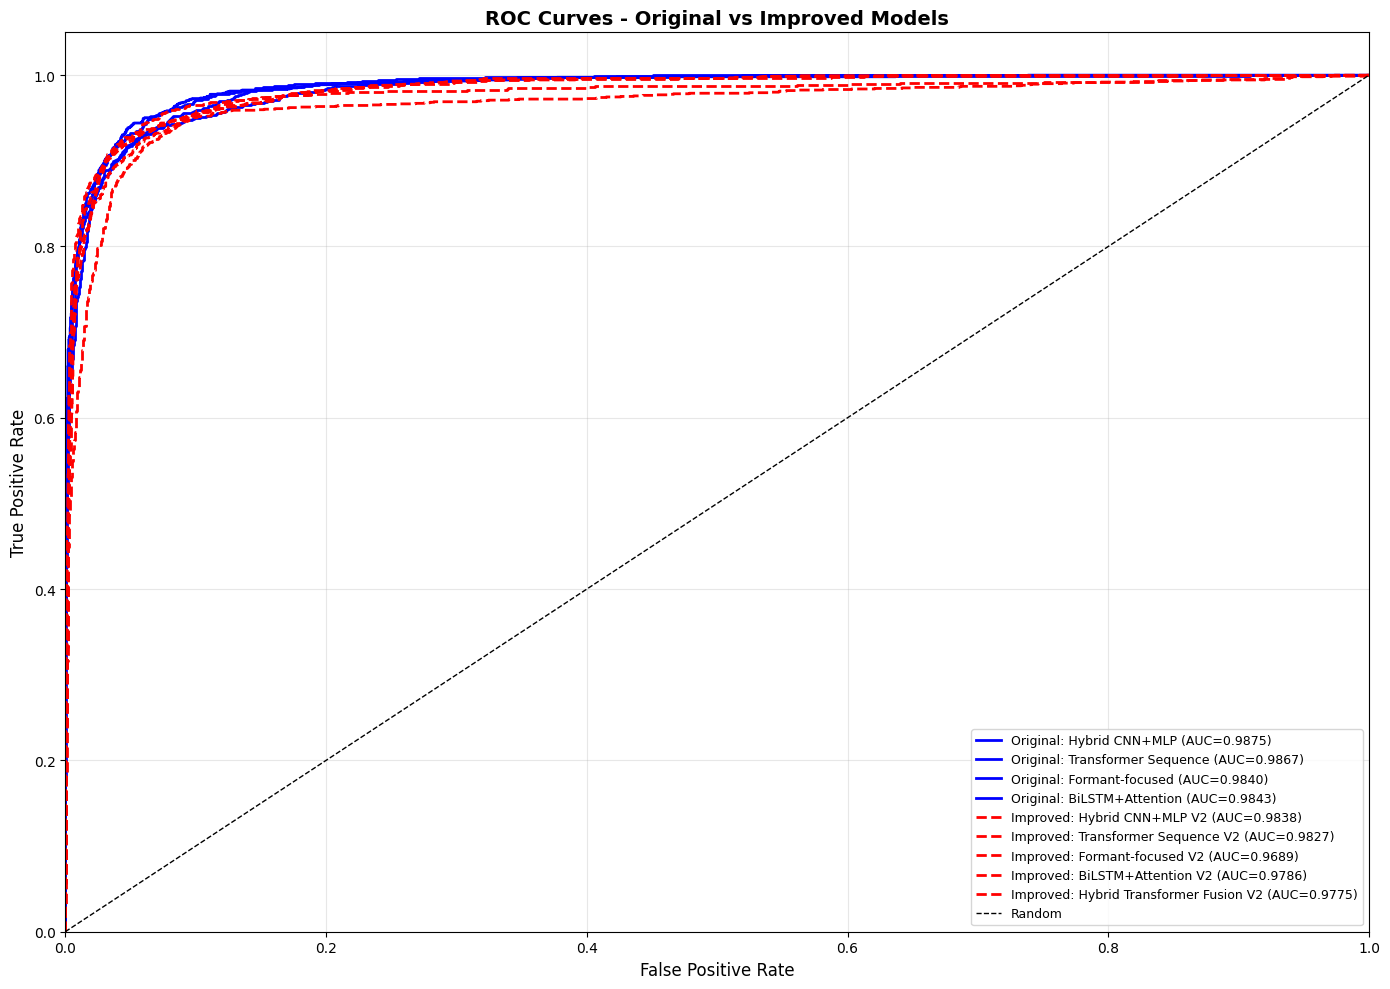

ROC curves saved.


In [37]:
# 1. ROC Curves
plt.figure(figsize=(14, 10))
for name, data in all_test_metrics.items():
    fpr, tpr, _ = roc_curve(data['labels'], np.array(data['probabilities'])[:, 1])
    roc_auc = auc(fpr, tpr)
    style = '-' if 'Original' in name else '--'
    color = 'blue' if 'Original' in name else 'red'
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.4f})", linewidth=2, linestyle=style, color=color)

plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Original vs Improved Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("ROC curves saved.")


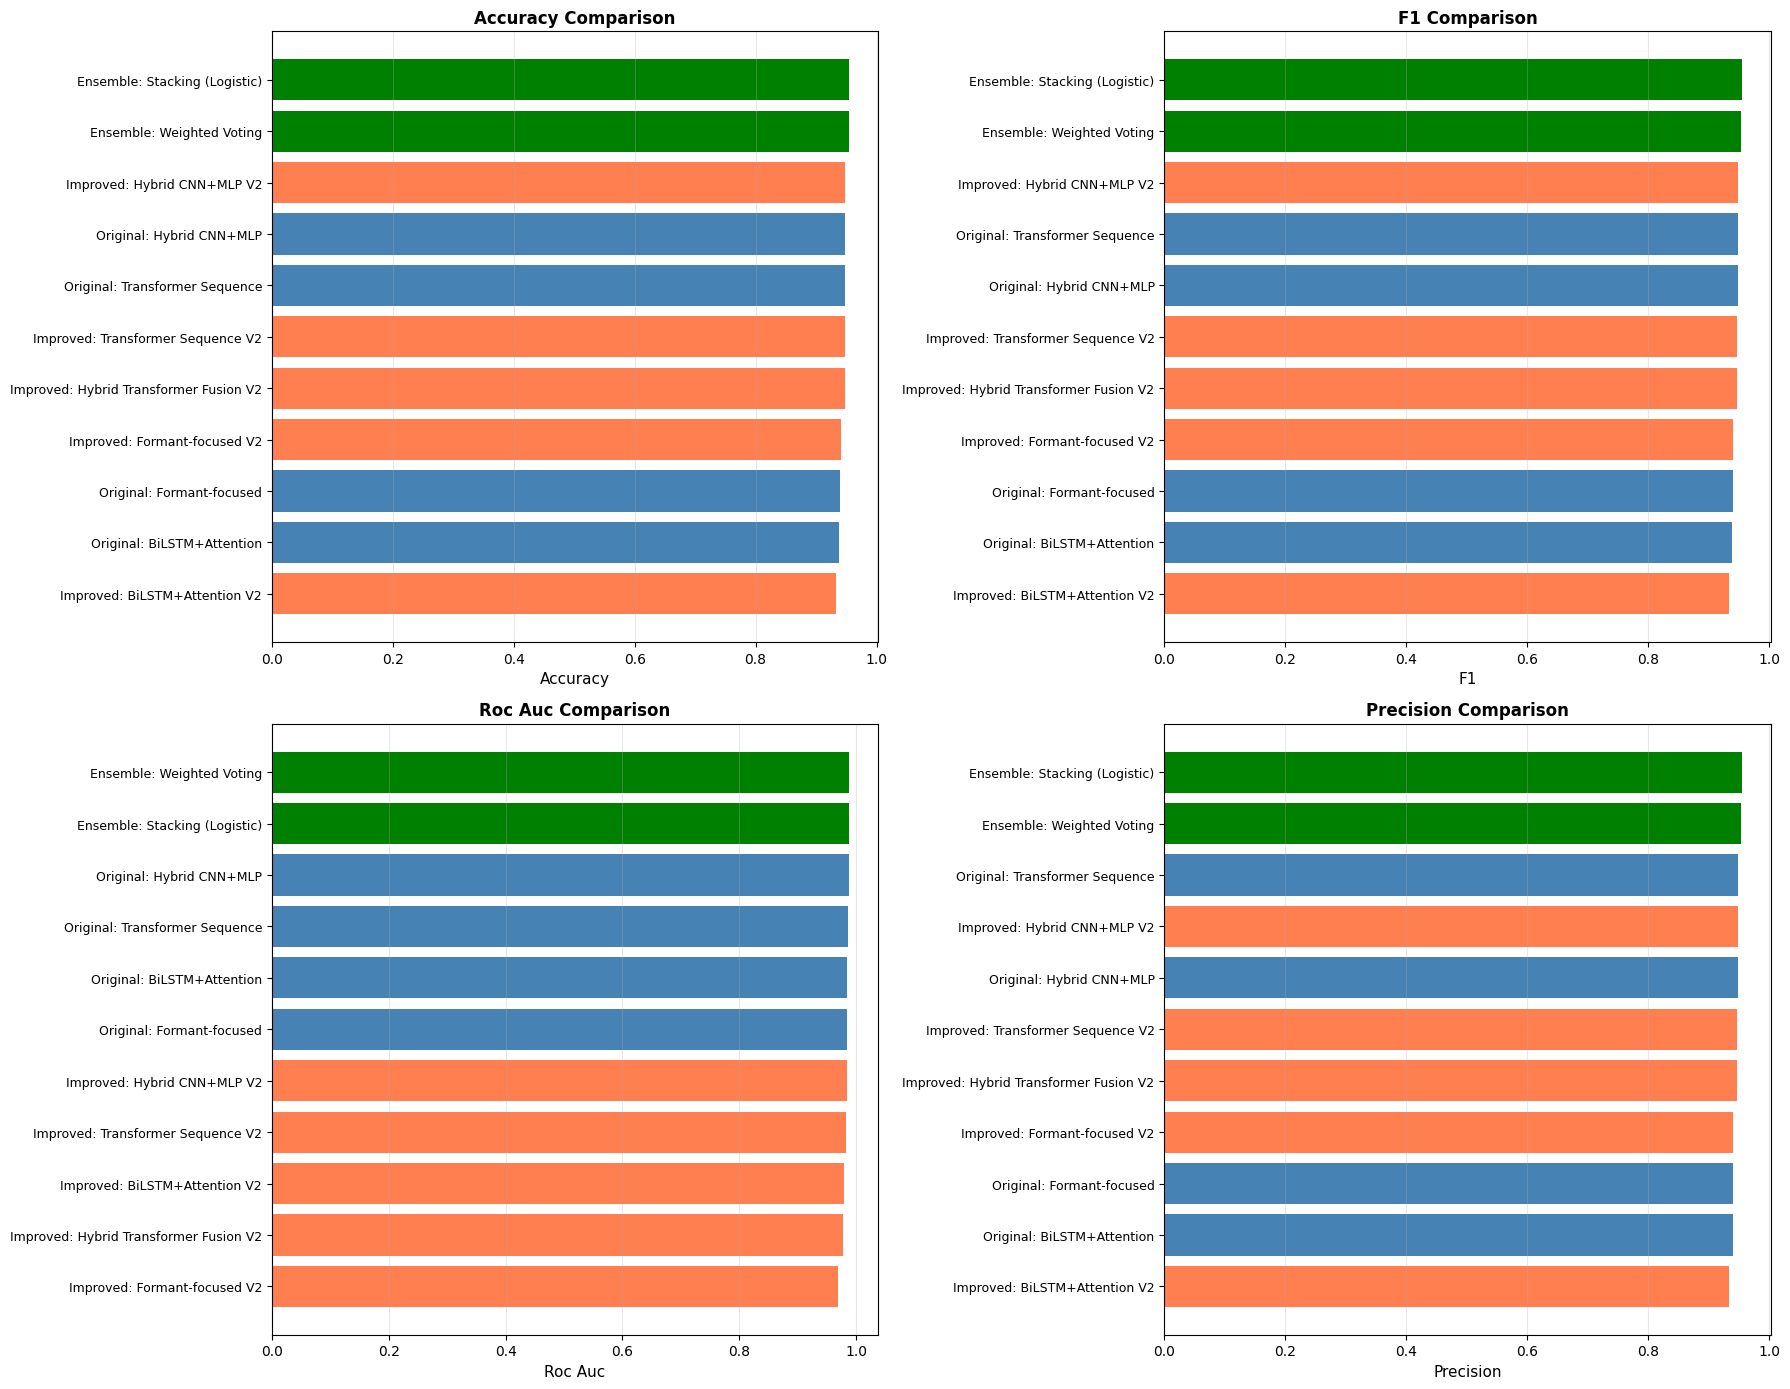

Metrics comparison saved.


In [38]:
# 2. Metrics Comparison Bar Chart
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

metrics_to_plot = ['accuracy', 'f1', 'roc_auc', 'precision']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    sorted_df = results_df.sort_values(metric, ascending=True)
    
    # Color by version
    colors = []
    for _, row in sorted_df.iterrows():
        if row['version'] == 'original':
            colors.append('steelblue')
        elif row['version'] == 'improved':
            colors.append('coral')
        else:
            colors.append('green')
    
    ax.barh(range(len(sorted_df)), sorted_df[metric], color=colors)
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['model_name'], fontsize=9)
    ax.set_xlabel(metric.replace('_', ' ').title(), fontsize=11)
    ax.set_title(f'{metric.replace("_", " ").title()} Comparison', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Metrics comparison saved.")


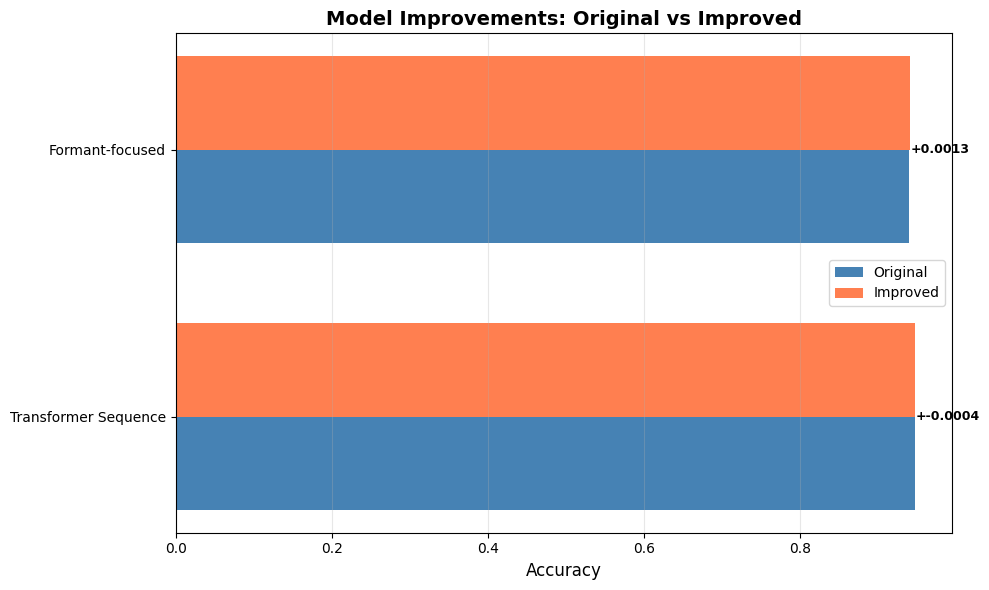

Improvements comparison saved.

Improvement Summary:
               Model  Original Accuracy  Improved Accuracy  Improvement
Transformer Sequence           0.947654           0.947280    -0.000374
     Formant-focused           0.939989           0.941297     0.001309


In [39]:
# 3. Improvement Comparison (Before/After)
original_models = results_df[results_df['version'] == 'original']
improved_models = results_df[results_df['version'] == 'improved']

# Match models by base name
improvements = []
for _, orig_row in original_models.iterrows():
    base_name = orig_row['model_name'].replace('Original: ', '').split(' V2')[0]
    improved_row = improved_models[improved_models['model_name'].str.contains(base_name)]
    
    if not improved_row.empty:
        improvements.append({
            'Model': base_name,
            'Original Accuracy': orig_row['accuracy'],
            'Improved Accuracy': improved_row.iloc[0]['accuracy'],
            'Improvement': improved_row.iloc[0]['accuracy'] - orig_row['accuracy']
        })

if improvements:
    improvements_df = pd.DataFrame(improvements)
    improvements_df = improvements_df.sort_values('Improvement', ascending=True)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(improvements_df))
    width = 0.35
    
    ax.barh(x - width/2, improvements_df['Original Accuracy'], width, label='Original', color='steelblue')
    ax.barh(x + width/2, improvements_df['Improved Accuracy'], width, label='Improved', color='coral')
    
    ax.set_yticks(x)
    ax.set_yticklabels(improvements_df['Model'])
    ax.set_xlabel('Accuracy', fontsize=12)
    ax.set_title('Model Improvements: Original vs Improved', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add improvement values
    for i, (_, row) in enumerate(improvements_df.iterrows()):
        ax.text(row['Improved Accuracy'] + 0.001, i, f"+{row['Improvement']:.4f}", 
                va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(COMPARISON_DIR / 'improvements.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Improvements comparison saved.")
    
    print("\n" + "="*60)
    print("Improvement Summary:")
    print("="*60)
    print(improvements_df.to_string(index=False))


## Generate Comparison Report


In [40]:
# Generate markdown report
# Initialize improvements if not already done
if 'improvements' not in locals():
    improvements = []
    improvements_df = pd.DataFrame()

report_lines = [
    "# Improved Models Comparison Report",
    "",
    f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}",
    "",
    "## Summary",
    f"Total models evaluated: {len(results_df)}",
    "",
    "## Top Models by Accuracy",
    ""
]

for rank, (_, row) in enumerate(results_df.nlargest(10, 'accuracy').iterrows(), 1):
    report_lines.extend([
        f"### Rank {rank}: {row['model_name']}",
        f"- **Version**: {row['version']}",
        f"- **Accuracy**: {row['accuracy']:.4f}",
        f"- **F1-score**: {row['f1']:.4f}",
        f"- **ROC-AUC**: {row['roc_auc']:.4f}",
        f"- **Precision**: {row['precision']:.4f}",
        f"- **Recall**: {row['recall']:.4f}",
        ""
    ])

if improvements and len(improvements) > 0:
    report_lines.extend([
        "## Improvements Summary",
        "",
        "| Model | Original Accuracy | Improved Accuracy | Improvement |",
        "|-------|------------------|------------------|-------------|"
    ])
    for _, row in improvements_df.iterrows():
        report_lines.append(
            f"| {row['Model']} | {row['Original Accuracy']:.4f} | {row['Improved Accuracy']:.4f} | +{row['Improvement']:.4f} |"
        )
    report_lines.append("")

report_lines.extend([
    "## Complete Results Table",
    "",
    "| Model | Version | Accuracy | F1 | ROC-AUC | Precision | Recall |",
    "|-------|---------|----------|----|---------|-----------|--------|"
])

for _, row in results_df.iterrows():
    report_lines.append(
        f"| {row['model_name']} | {row['version']} | {row['accuracy']:.4f} | {row['f1']:.4f} | "
        f"{row['roc_auc']:.4f} | {row['precision']:.4f} | {row['recall']:.4f} |"
    )

report_lines.extend([
    "",
    "## Recommendations",
    "",
    f"**Best overall model**: {results_df.iloc[0]['model_name']} (Accuracy: {results_df.iloc[0]['accuracy']:.4f})",
    "",
    f"**Best improved model**: {results_df[results_df['version'] == 'improved'].iloc[0]['model_name']} "
    f"(Accuracy: {results_df[results_df['version'] == 'improved'].iloc[0]['accuracy']:.4f})",
    ""
])

# Save report
report_path = COMPARISON_DIR / 'comparison_report.md'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write('\n'.join(report_lines))

print(f"\nReport saved to {report_path}")
print(f"\nTop 5 models:")
for i, (_, row) in enumerate(results_df.nlargest(5, 'accuracy').iterrows(), 1):
    print(f"{i}. {row['model_name']}: Acc={row['accuracy']:.4f}, F1={row['f1']:.4f}, ROC-AUC={row['roc_auc']:.4f}")



Report saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dl_models/improved_models/comparison/comparison_report.md

Top 5 models:
1. Ensemble: Stacking (Logistic): Acc=0.9549, F1=0.9547, ROC-AUC=0.9878
2. Ensemble: Weighted Voting: Acc=0.9538, F1=0.9537, ROC-AUC=0.9881
3. Improved: Hybrid CNN+MLP V2: Acc=0.9484, F1=0.9481, ROC-AUC=0.9838
4. Original: Hybrid CNN+MLP: Acc=0.9478, F1=0.9478, ROC-AUC=0.9875
5. Original: Transformer Sequence: Acc=0.9477, F1=0.9479, ROC-AUC=0.9867


## Top 3 Models Detailed Analysis


In [41]:
# Get top 3 models
top3_models = results_df.nlargest(3, 'accuracy')
print("Top 3 Models:")
for i, (_, row) in enumerate(top3_models.iterrows(), 1):
    print(f"{i}. {row['model_name']}: Acc={row['accuracy']:.4f}, F1={row['f1']:.4f}")

# For ensemble models, we need to get their predictions
# Load ensemble predictions if they're not in all_test_metrics
top3_metrics = {}
for _, row in top3_models.iterrows():
    model_name = row['model_name']
    
    if model_name in all_test_metrics:
        # Already have predictions
        top3_metrics[model_name] = all_test_metrics[model_name]
    elif 'Ensemble' in model_name:
        # Need to compute ensemble predictions
        print(f"\nComputing predictions for {model_name}...")
        
        # Load all improved models for ensemble
        from models.hybrid.hybrid_cnn_mlp_v2 import HybridCNNMLP_V2
        from models.sequence.transformer_sequence_v2 import TransformerSequence_V2
        from models.specialized.formant_focused_v2 import FormantFocusedModel_V2
        from models.sequence.bilstm_attention_v2 import BiLSTMAttention_V2
        from utils.ensemble_utils import get_model_predictions, weighted_voting, stacking_ensemble
        
        models_list = []
        
        # Model 1: Hybrid CNN+MLP V2
        model1 = HybridCNNMLP_V2(n_features=len(feature_cols), num_classes=2).to(device)
        checkpoint1 = torch.load(IMPROVED_DIR / 'hybrid_cnn_mlp_v2' / 'best_model.pt')
        model1.load_state_dict(checkpoint1['model_state_dict'])
        models_list.append((model1, 'Hybrid CNN+MLP V2'))
        
        # Model 2: Transformer Sequence V2
        model2 = TransformerSequence_V2(
            input_dim=128, d_model=256, nhead=8, num_layers=6, 
            dim_feedforward=1024, dropout=0.1, num_classes=2, batch_first=True
        ).to(device)
        checkpoint2 = torch.load(IMPROVED_DIR / 'transformer_sequence_v2' / 'best_model.pt')
        model2.load_state_dict(checkpoint2['model_state_dict'])
        models_list.append((model2, 'Transformer Sequence V2'))
        
        # Model 3: Formant-focused V2
        model3 = FormantFocusedModel_V2(n_features=len(feature_cols), num_classes=2).to(device)
        model3.set_formant_indices(feature_cols, ['formant_f1', 'formant_f2', 'formant_f3'])
        checkpoint3 = torch.load(IMPROVED_DIR / 'formant_focused_v2' / 'best_model.pt')
        model3.load_state_dict(checkpoint3['model_state_dict'])
        models_list.append((model3, 'Formant-focused V2'))
        
        # Model 4: BiLSTM+Attention V2
        model4 = BiLSTMAttention_V2(
            input_dim=128, hidden_dim=128, num_layers=3, 
            num_classes=2, dropout=0.3, num_heads=4
        ).to(device)
        checkpoint4 = torch.load(IMPROVED_DIR / 'bilstm_attention_v2' / 'best_model.pt')
        model4.load_state_dict(checkpoint4['model_state_dict'])
        models_list.append((model4, 'BiLSTM+Attention V2'))
        
        # Get predictions from all models on test set
        # Use hybrid loader for all (they all use sequence/spectrogram data)
        test_loader = dataloaders['hybrid']['test']
        
        # Get individual model predictions
        test_probs_list = []
        test_labels = None
        
        for model, name in models_list:
            # Get appropriate loader
            if 'Hybrid' in name:
                loader = dataloaders['hybrid']['test']
            elif 'Transformer' in name or 'BiLSTM' in name:
                loader = dataloaders['sequence']['test']
            else:  # Formant-focused
                loader = dataloaders['feature']['test']
            
            probs, labels = get_model_predictions([(model, name)], loader, device)
            test_probs_list.append(probs[0])
            if test_labels is None:
                test_labels = labels
        
        # Compute ensemble predictions
        if 'Weighted Voting' in model_name:
            # Calculate weights from F1 scores
            from sklearn.metrics import f1_score
            model_weights = []
            for probs in test_probs_list:
                preds = np.argmax(probs, axis=1)
                f1 = f1_score(test_labels, preds, average='weighted')
                model_weights.append(f1)
            ensemble_probs, ensemble_preds = weighted_voting(test_probs_list, weights=model_weights)
        elif 'Stacking' in model_name:
            # For stacking, we need validation predictions too
            val_probs_list = []
            val_labels = None
            
            for model, name in models_list:
                if 'Hybrid' in name:
                    loader = dataloaders['hybrid']['val']
                elif 'Transformer' in name or 'BiLSTM' in name:
                    loader = dataloaders['sequence']['val']
                else:
                    loader = dataloaders['feature']['val']
                
                probs, labels = get_model_predictions([(model, name)], loader, device)
                val_probs_list.append(probs[0])
                if val_labels is None:
                    val_labels = labels
            
            # Use logistic stacking
            ensemble_preds, ensemble_probs, _ = stacking_ensemble(
                val_probs_list, val_labels,
                val_probs_list, val_labels,
                test_probs_list, test_labels,
                meta_model_type='logistic'
            )
            # Convert to probabilities format (n_samples, n_classes)
            if len(ensemble_probs.shape) == 1:
                ensemble_probs = np.column_stack([1 - ensemble_probs, ensemble_probs])
        else:
            # Simple voting
            ensemble_probs, ensemble_preds = weighted_voting(test_probs_list)
        
        # Store metrics
        from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
        
        top3_metrics[model_name] = {
            'metrics': {
                'accuracy': accuracy_score(test_labels, ensemble_preds),
                'f1': f1_score(test_labels, ensemble_preds, average='weighted'),
                'roc_auc': roc_auc_score(test_labels, ensemble_probs[:, 1]),
                'precision': precision_score(test_labels, ensemble_preds, average='weighted'),
                'recall': recall_score(test_labels, ensemble_preds, average='weighted')
            },
            'predictions': ensemble_preds,
            'labels': test_labels,
            'probabilities': ensemble_probs
        }
        
        print(f"Computed predictions for {model_name}")

print(f"\nPrepared metrics for {len(top3_metrics)} top models")


Top 3 Models:
1. Ensemble: Stacking (Logistic): Acc=0.9549, F1=0.9547
2. Ensemble: Weighted Voting: Acc=0.9538, F1=0.9537
3. Improved: Hybrid CNN+MLP V2: Acc=0.9484, F1=0.9481

Computing predictions for Ensemble: Stacking (Logistic)...


Meta-model validation - Acc: 0.9588, F1: 0.9587
Computed predictions for Ensemble: Stacking (Logistic)

Computing predictions for Ensemble: Weighted Voting...


Computed predictions for Ensemble: Weighted Voting

Prepared metrics for 3 top models


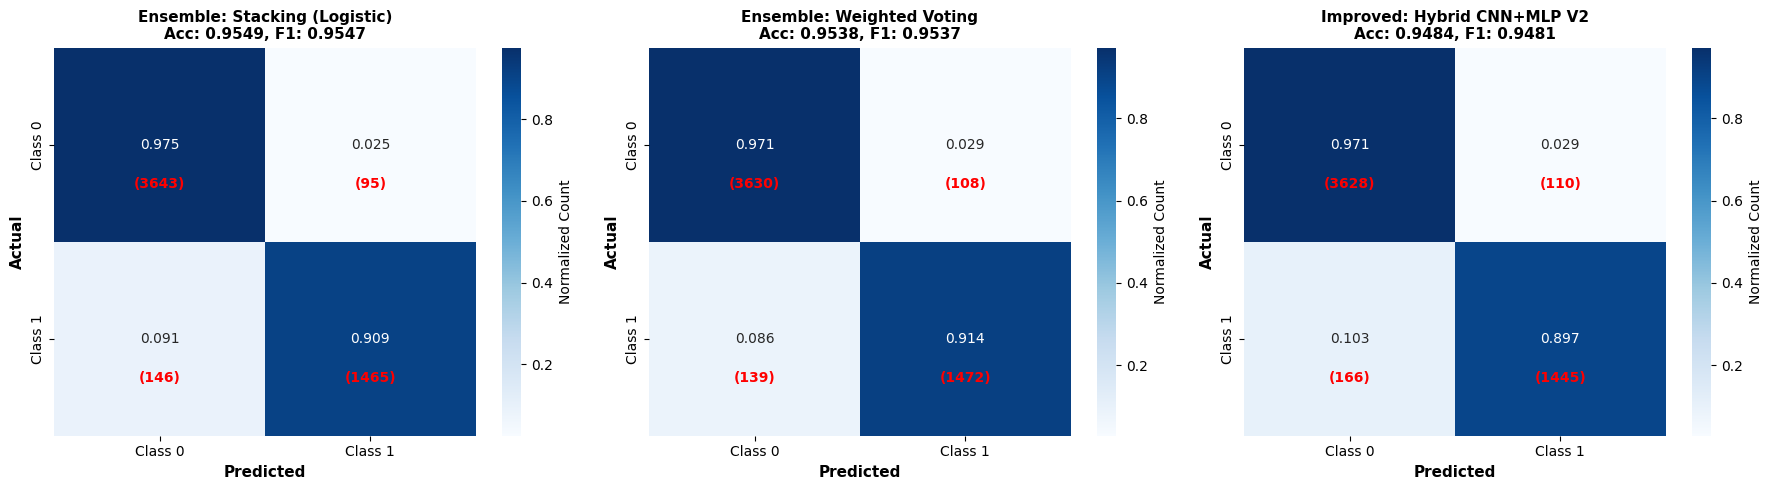

Confusion matrices saved.


In [42]:
# 1. Confusion Matrices for Top 3 Models
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (_, row) in enumerate(top3_models.iterrows()):
    model_name = row['model_name']
    data = top3_metrics[model_name]
    
    cm = confusion_matrix(data['labels'], data['predictions'])
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    ax = axes[idx]
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], 
                yticklabels=['Class 0', 'Class 1'],
                ax=ax, cbar_kws={'label': 'Normalized Count'})
    
    # Add raw counts as text
    for i in range(2):
        for j in range(2):
            ax.text(j+0.5, i+0.7, f'({cm[i,j]})', 
                   ha='center', va='center', fontsize=10, color='red', fontweight='bold')
    
    ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}\nAcc: {row["accuracy"]:.4f}, F1: {row["f1"]:.4f}', 
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'top3_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("Confusion matrices saved.")


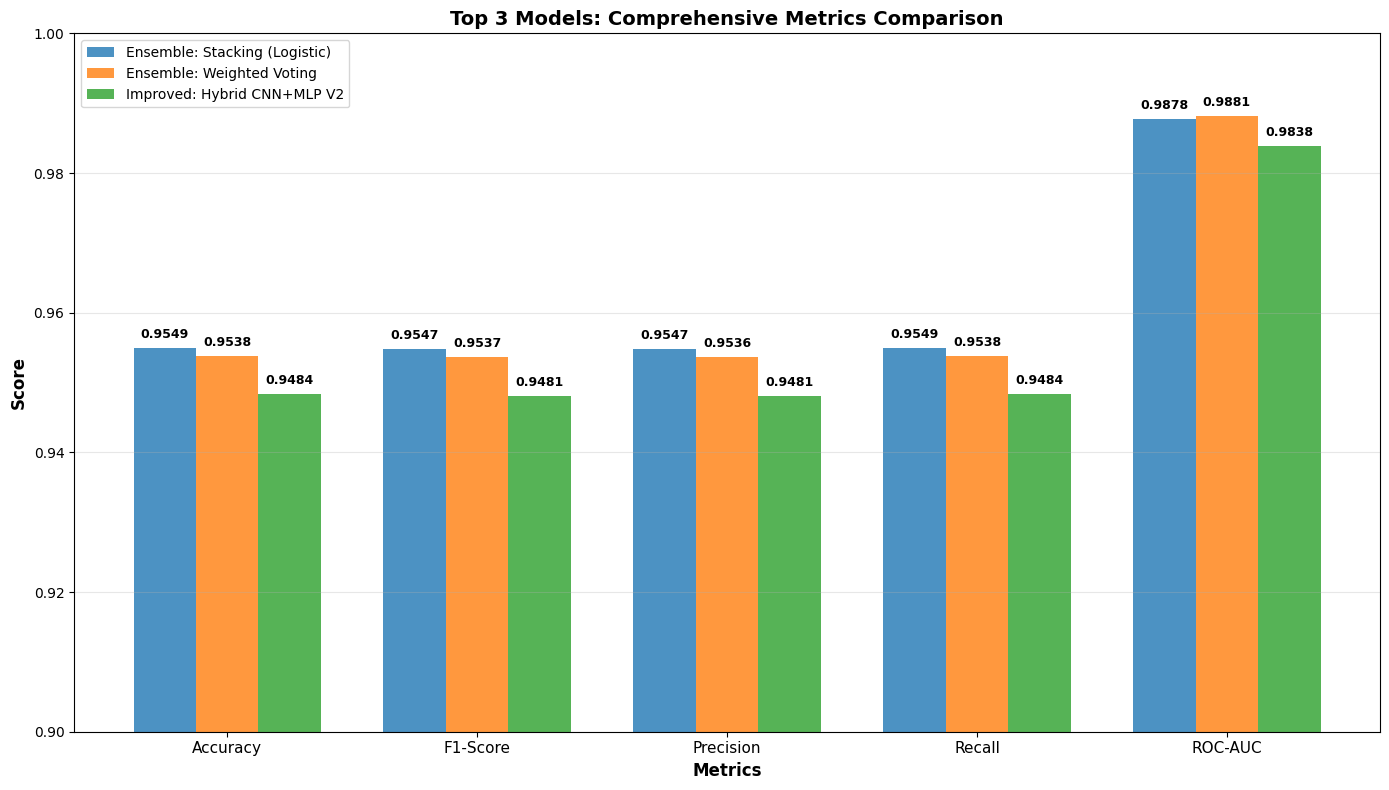

Metrics comparison saved.


In [43]:
# 2. Metrics Comparison Bar Chart for Top 3
metrics_to_compare = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
metric_names = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC-AUC']

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(metrics_to_compare))
width = 0.25

for idx, (_, row) in enumerate(top3_models.iterrows()):
    model_name = row['model_name']
    values = [row[metric] for metric in metrics_to_compare]
    
    offset = (idx - 1) * width
    bars = ax.bar(x + offset, values, width, label=model_name, alpha=0.8)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
               f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Top 3 Models: Comprehensive Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metric_names, fontsize=11)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0.90, 1.0])

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'top3_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Metrics comparison saved.")


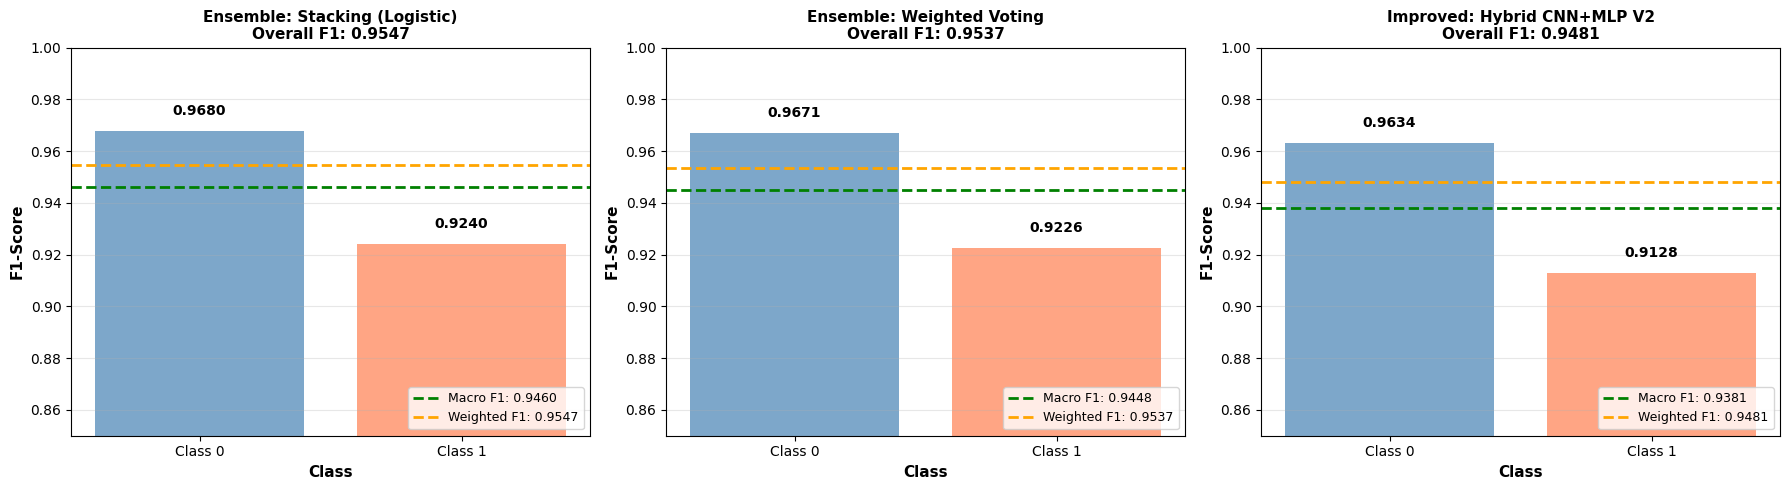

F1 breakdown saved.


In [44]:
# 3. F1-Score Detailed Breakdown
from sklearn.metrics import f1_score, classification_report

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (_, row) in enumerate(top3_models.iterrows()):
    model_name = row['model_name']
    data = top3_metrics[model_name]
    
    # Calculate per-class F1 scores
    f1_per_class = f1_score(data['labels'], data['predictions'], average=None)
    f1_macro = f1_score(data['labels'], data['predictions'], average='macro')
    f1_weighted = f1_score(data['labels'], data['predictions'], average='weighted')
    
    ax = axes[idx]
    
    # Bar chart for per-class F1
    classes = ['Class 0', 'Class 1']
    x_pos = np.arange(len(classes))
    bars = ax.bar(x_pos, f1_per_class, alpha=0.7, color=['steelblue', 'coral'])
    
    # Add value labels
    for bar, val in zip(bars, f1_per_class):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
               f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Add macro and weighted F1 as horizontal lines
    ax.axhline(y=f1_macro, color='green', linestyle='--', linewidth=2, label=f'Macro F1: {f1_macro:.4f}')
    ax.axhline(y=f1_weighted, color='orange', linestyle='--', linewidth=2, label=f'Weighted F1: {f1_weighted:.4f}')
    
    ax.set_xlabel('Class', fontsize=11, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}\nOverall F1: {row["f1"]:.4f}', fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(classes)
    ax.set_ylim([0.85, 1.0])
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'top3_f1_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()
print("F1 breakdown saved.")


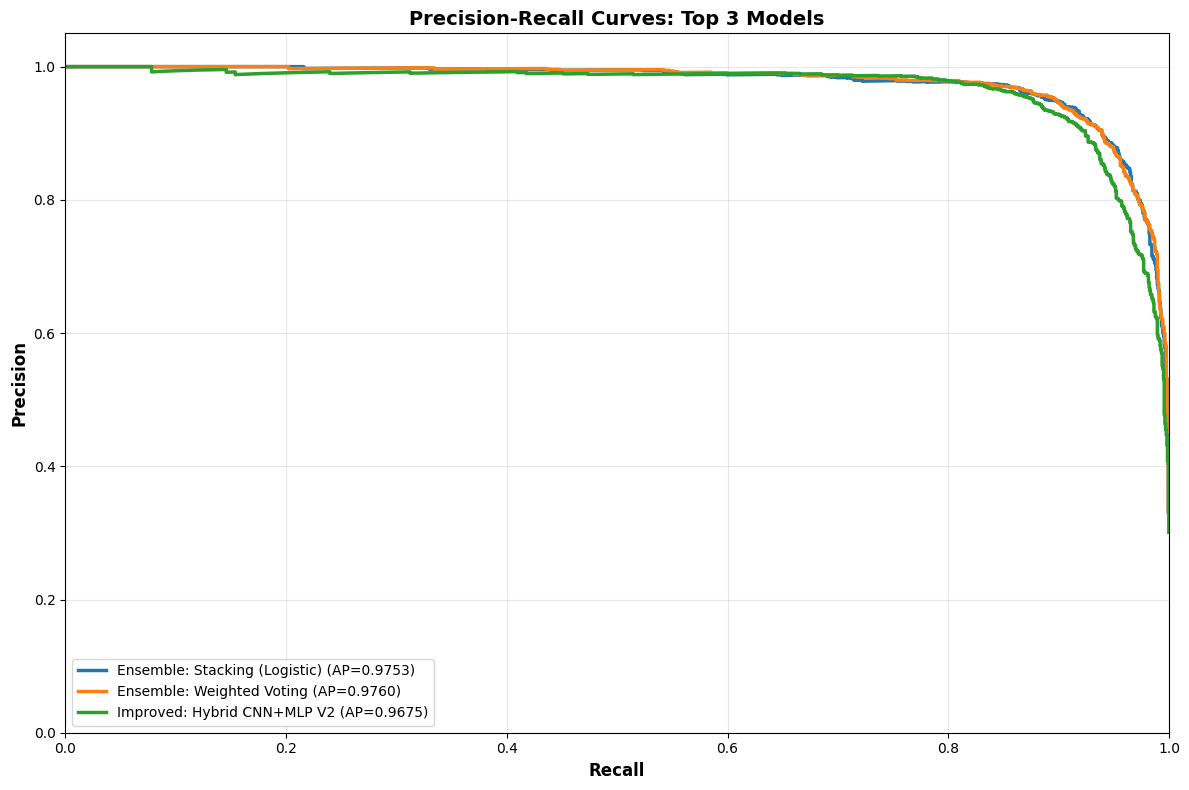

Precision-Recall curves saved.


In [45]:
# 4. Precision-Recall Curves for Top 3
from sklearn.metrics import precision_recall_curve, average_precision_score

fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (_, row) in enumerate(top3_models.iterrows()):
    model_name = row['model_name']
    data = top3_metrics[model_name]
    
    # Convert to numpy arrays if needed
    labels = np.array(data['labels'])
    probs = np.array(data['probabilities'])
    
    # Ensure probabilities have correct shape (n_samples, n_classes)
    if len(probs.shape) == 1:
        # If 1D, assume it's probabilities for class 1
        probs_class1 = probs
    else:
        # If 2D, extract class 1 probabilities
        probs_class1 = probs[:, 1] if probs.shape[1] > 1 else probs[:, 0]
    
    precision, recall, _ = precision_recall_curve(labels, probs_class1)
    ap_score = average_precision_score(labels, probs_class1)
    
    ax.plot(recall, precision, linewidth=2.5, label=f'{model_name} (AP={ap_score:.4f})', 
           color=colors[idx % len(colors)])

ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curves: Top 3 Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'top3_precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("Precision-Recall curves saved.")


In [46]:
# 5. Classification Report Table for Top 3
from sklearn.metrics import classification_report

print("="*80)
print("DETAILED CLASSIFICATION REPORTS FOR TOP 3 MODELS")
print("="*80)

for idx, (_, row) in enumerate(top3_models.iterrows(), 1):
    model_name = row['model_name']
    data = top3_metrics[model_name]
    
    print(f"\n{'='*80}")
    print(f"Model {idx}: {model_name}")
    print(f"{'='*80}")
    print(classification_report(data['labels'], data['predictions'], 
                              target_names=['Class 0', 'Class 1'], digits=4))
    
    # Additional metrics
    print(f"Overall Accuracy: {row['accuracy']:.4f}")
    print(f"ROC-AUC: {row['roc_auc']:.4f}")
    print(f"Weighted F1: {row['f1']:.4f}")
    print(f"Weighted Precision: {row['precision']:.4f}")
    print(f"Weighted Recall: {row['recall']:.4f}")


DETAILED CLASSIFICATION REPORTS FOR TOP 3 MODELS

Model 1: Ensemble: Stacking (Logistic)
              precision    recall  f1-score   support

     Class 0     0.9615    0.9746    0.9680      3738
     Class 1     0.9391    0.9094    0.9240      1611

    accuracy                         0.9549      5349
   macro avg     0.9503    0.9420    0.9460      5349
weighted avg     0.9547    0.9549    0.9547      5349

Overall Accuracy: 0.9549
ROC-AUC: 0.9878
Weighted F1: 0.9547
Weighted Precision: 0.9547
Weighted Recall: 0.9549

Model 2: Ensemble: Weighted Voting
              precision    recall  f1-score   support

     Class 0     0.9631    0.9711    0.9671      3738
     Class 1     0.9316    0.9137    0.9226      1611

    accuracy                         0.9538      5349
   macro avg     0.9474    0.9424    0.9448      5349
weighted avg     0.9536    0.9538    0.9537      5349

Overall Accuracy: 0.9538
ROC-AUC: 0.9881
Weighted F1: 0.9537
Weighted Precision: 0.9536
Weighted Recall: 0.95

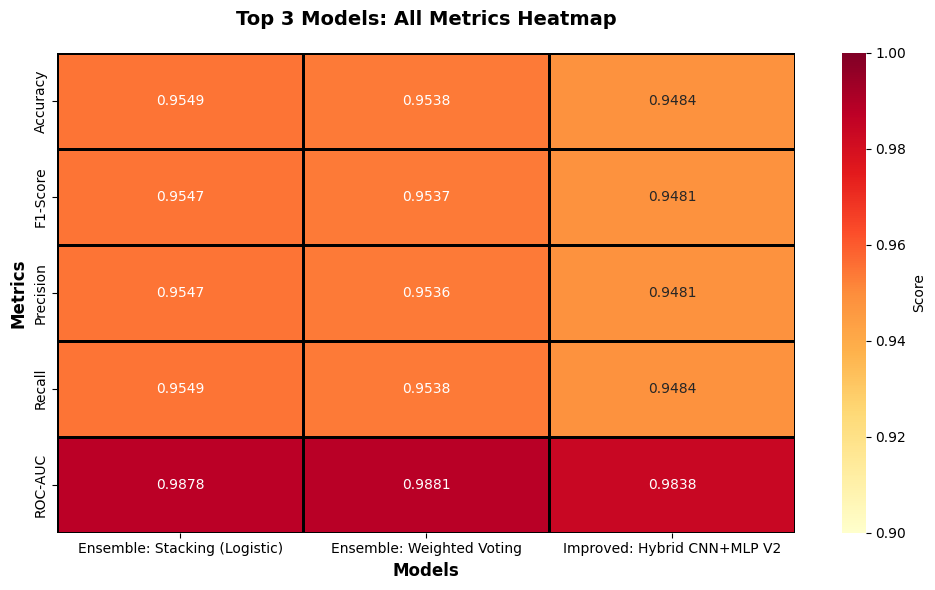

Metrics heatmap saved.


In [47]:
# 6. Side-by-side Comparison: All Metrics Heatmap
metrics_data = []
for _, row in top3_models.iterrows():
    metrics_data.append({
        'Model': row['model_name'],
        'Accuracy': row['accuracy'],
        'F1-Score': row['f1'],
        'Precision': row['precision'],
        'Recall': row['recall'],
        'ROC-AUC': row['roc_auc']
    })

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.set_index('Model')

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(metrics_df.T, annot=True, fmt='.4f', cmap='YlOrRd', 
            cbar_kws={'label': 'Score'}, ax=ax, vmin=0.90, vmax=1.0,
            linewidths=1, linecolor='black')

ax.set_title('Top 3 Models: All Metrics Heatmap', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Metrics', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'top3_metrics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Metrics heatmap saved.")


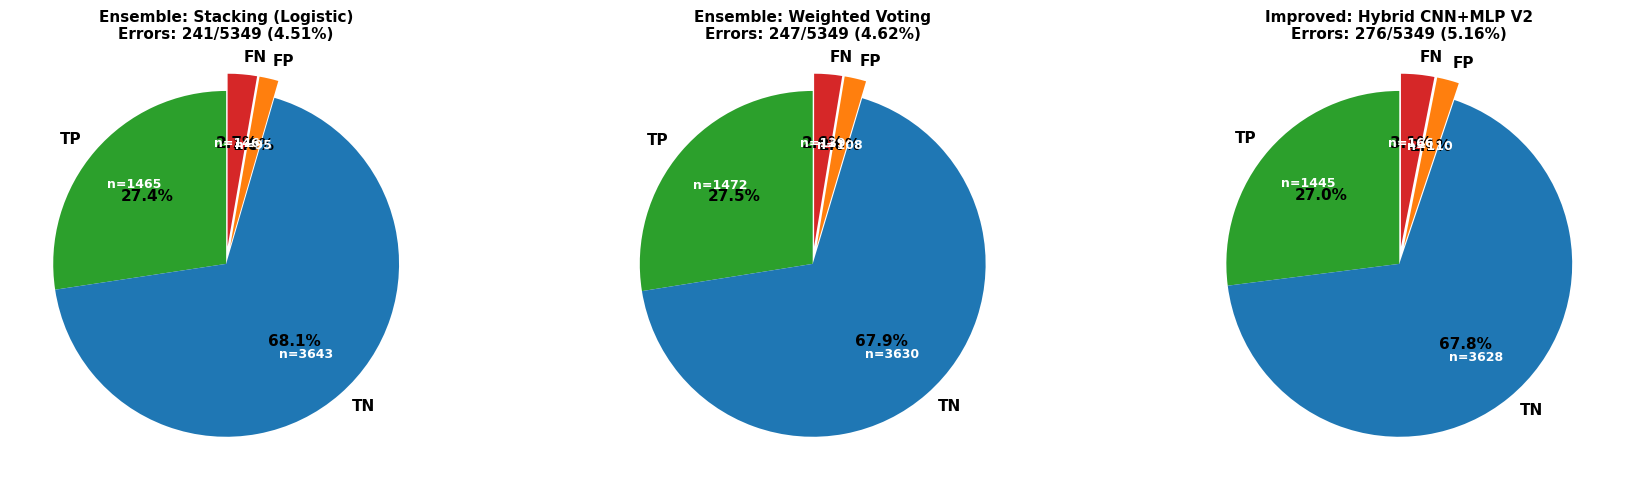

Error analysis saved.


In [48]:
# 7. Error Analysis: Misclassification Patterns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (_, row) in enumerate(top3_models.iterrows()):
    model_name = row['model_name']
    data = top3_metrics[model_name]
    
    # Convert to numpy arrays if needed
    y_true = np.array(data['labels'])
    y_pred = np.array(data['predictions'])
    
    # Identify misclassifications
    correct = y_true == y_pred
    incorrect = ~correct
    
    # Count misclassifications by type
    false_positives = ((y_true == 0) & (y_pred == 1)).sum()
    false_negatives = ((y_true == 1) & (y_pred == 0)).sum()
    true_positives = ((y_true == 1) & (y_pred == 1)).sum()
    true_negatives = ((y_true == 0) & (y_pred == 0)).sum()
    
    # Create pie chart
    ax = axes[idx]
    
    sizes = [true_positives, true_negatives, false_positives, false_negatives]
    pie_labels = ['TP', 'TN', 'FP', 'FN']
    colors_pie = ['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728']
    explode = (0, 0, 0.1, 0.1)  # Explode FP and FN
    
    wedges, texts, autotexts = ax.pie(sizes, labels=pie_labels, colors=colors_pie, autopct='%1.1f%%',
                                      startangle=90, explode=explode, textprops={'fontsize': 11, 'fontweight': 'bold'})
    
    # Add counts
    for i, (wedge, size) in enumerate(zip(wedges, sizes)):
        if size > 0:
            angle = (wedge.theta2 + wedge.theta1) / 2
            x = wedge.r * 0.7 * np.cos(np.deg2rad(angle))
            y = wedge.r * 0.7 * np.sin(np.deg2rad(angle))
            ax.text(x, y, f'n={size}', ha='center', va='center', 
                   fontsize=9, fontweight='bold', color='white')
    
    ax.set_title(f'{model_name}\nErrors: {incorrect.sum()}/{len(y_true)} ({100*incorrect.sum()/len(y_true):.2f}%)', 
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'top3_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Error analysis saved.")


In [49]:
# Summary: Save all top 3 visualizations info
print("\n" + "="*80)
print("TOP 3 MODELS VISUALIZATION SUMMARY")
print("="*80)
print(f"\nAll visualizations saved to: {COMPARISON_DIR}")
print("\nGenerated files:")
print("  1. top3_confusion_matrices.png - Confusion matrices for each model")
print("  2. top3_metrics_comparison.png - Bar chart comparing all metrics")
print("  3. top3_f1_breakdown.png - Per-class F1 scores")
print("  4. top3_precision_recall_curves.png - Precision-Recall curves")
print("  5. top3_metrics_heatmap.png - Heatmap of all metrics")
print("  6. top3_error_analysis.png - Error pattern analysis")
print("\n" + "="*80)



TOP 3 MODELS VISUALIZATION SUMMARY

All visualizations saved to: /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dl_models/improved_models/comparison

Generated files:
  1. top3_confusion_matrices.png - Confusion matrices for each model
  2. top3_metrics_comparison.png - Bar chart comparing all metrics
  3. top3_f1_breakdown.png - Per-class F1 scores
  4. top3_precision_recall_curves.png - Precision-Recall curves
  5. top3_metrics_heatmap.png - Heatmap of all metrics
  6. top3_error_analysis.png - Error pattern analysis



## Top 3 Individual Models Comparison (without ensembles)

In [50]:
# Get TOP 3 individual models (excluding ensembles)
top3_individual_models = results_df[results_df['version'] != 'ensemble'].nlargest(3, 'accuracy')

print("="*80)
print("TOP 3 MODELS (without ensembles)")
print("="*80)
for i, (_, row) in enumerate(top3_individual_models.iterrows(), 1):
    print(f"{i}. {row['model_name']}: Acc={row['accuracy']:.4f}, F1={row['f1']:.4f}, ROC-AUC={row['roc_auc']:.4f}")

# Prepare data for visualizations
top3_individual_metrics = {}
for _, row in top3_individual_models.iterrows():
    model_name = row['model_name']
    if model_name in all_test_metrics:
        top3_individual_metrics[model_name] = all_test_metrics[model_name]
    else:
        print(f"Warning: {model_name} not found in all_test_metrics")

print(f"\nPrepared data for {len(top3_individual_metrics)} models")

TOP 3 MODELS (without ensembles)
1. Improved: Hybrid CNN+MLP V2: Acc=0.9484, F1=0.9481, ROC-AUC=0.9838
2. Original: Hybrid CNN+MLP: Acc=0.9478, F1=0.9478, ROC-AUC=0.9875
3. Original: Transformer Sequence: Acc=0.9477, F1=0.9479, ROC-AUC=0.9867

Prepared data for 3 models


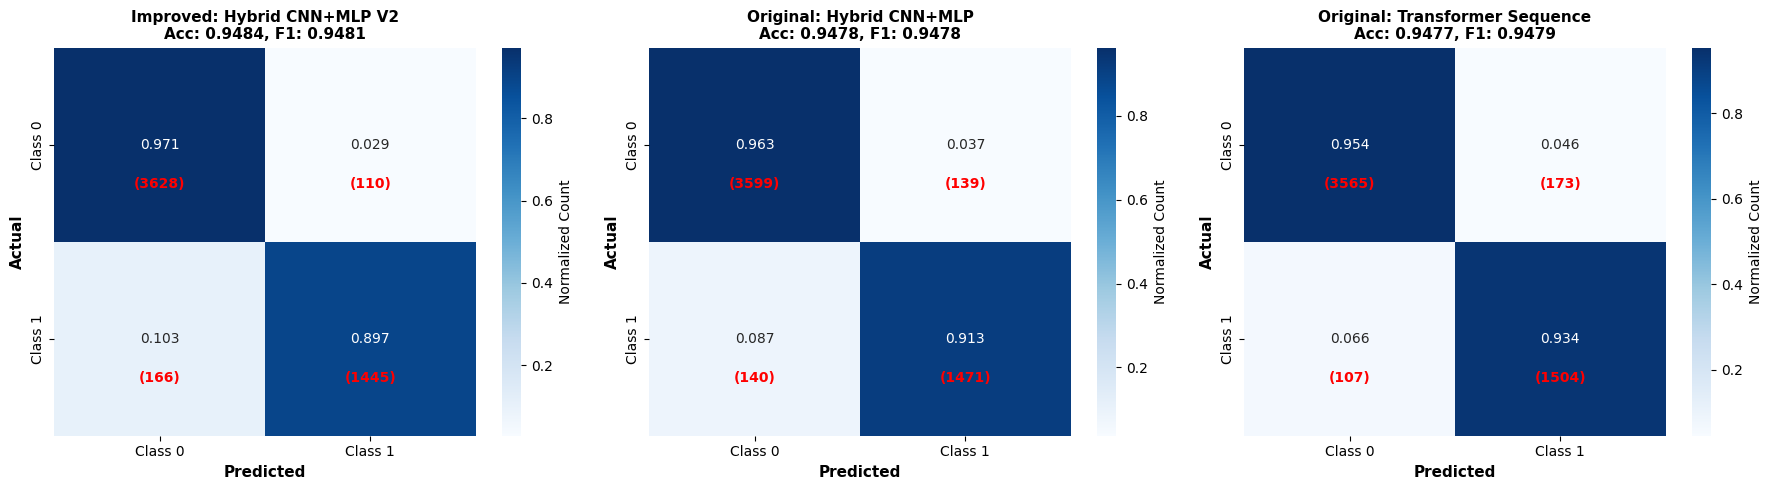

Confusion matrices for TOP 3 models saved.


In [51]:
# 1. Confusion Matrices for TOP 3 individual models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (_, row) in enumerate(top3_individual_models.iterrows()):
    model_name = row['model_name']
    data = top3_individual_metrics[model_name]
    
    cm = confusion_matrix(data['labels'], data['predictions'])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    ax = axes[idx]
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], 
                yticklabels=['Class 0', 'Class 1'],
                ax=ax, cbar_kws={'label': 'Normalized Count'})
    
    # Add raw counts
    for i in range(2):
        for j in range(2):
            ax.text(j+0.5, i+0.7, f'({cm[i,j]})', 
                   ha='center', va='center', fontsize=10, color='red', fontweight='bold')
    
    ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}\nAcc: {row["accuracy"]:.4f}, F1: {row["f1"]:.4f}', 
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'top3_individual_models_confusion.png', dpi=300, bbox_inches='tight')
plt.show()
print("Confusion matrices for TOP 3 models saved.")

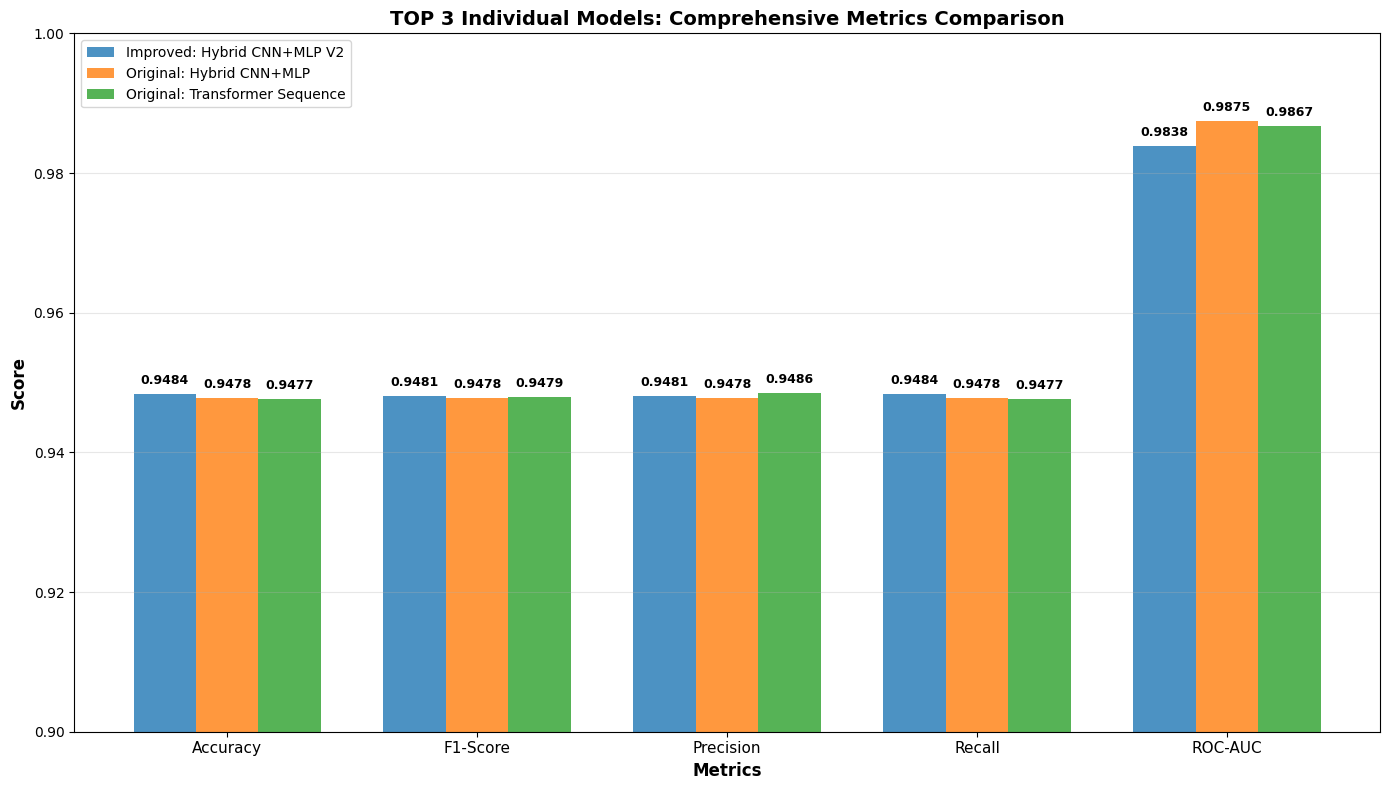

Metrics comparison saved.


In [52]:
# 2. Metrics Comparison for TOP 3 individual models
metrics_to_compare = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
metric_names = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC-AUC']

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(metrics_to_compare))
width = 0.25

for idx, (_, row) in enumerate(top3_individual_models.iterrows()):
    model_name = row['model_name']
    values = [row[metric] for metric in metrics_to_compare]
    
    offset = (idx - 1) * width
    bars = ax.bar(x + offset, values, width, label=model_name, alpha=0.8)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
               f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('TOP 3 Individual Models: Comprehensive Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metric_names, fontsize=11)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0.90, 1.0])

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'top3_individual_models_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print("Metrics comparison saved.")

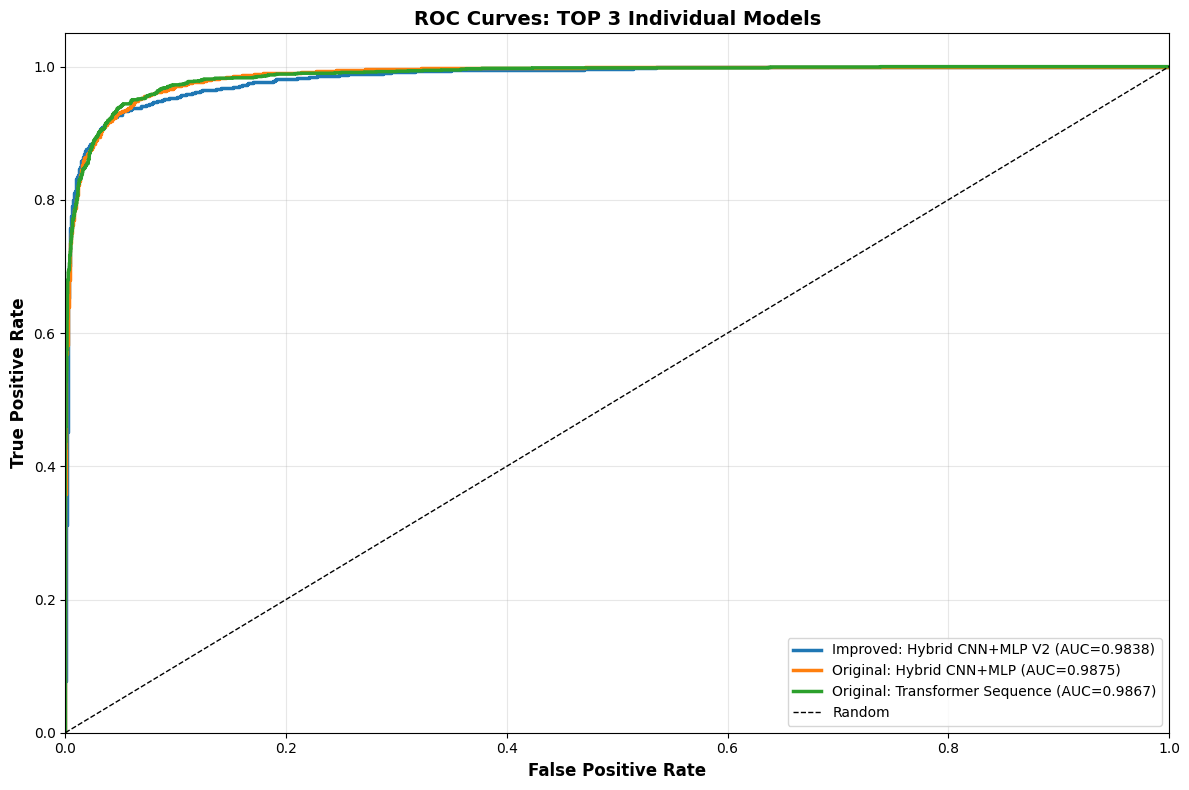

ROC curves saved.


In [53]:
# 3. ROC Curves for TOP 3 individual models
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (_, row) in enumerate(top3_individual_models.iterrows()):
    model_name = row['model_name']
    data = top3_individual_metrics[model_name]
    
    fpr, tpr, _ = roc_curve(data['labels'], np.array(data['probabilities'])[:, 1])
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, linewidth=2.5, label=f'{model_name} (AUC={roc_auc:.4f})', 
           color=colors[idx % len(colors)])

ax.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves: TOP 3 Individual Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'top3_individual_models_roc.png', dpi=300, bbox_inches='tight')
plt.show()
print("ROC curves saved.")

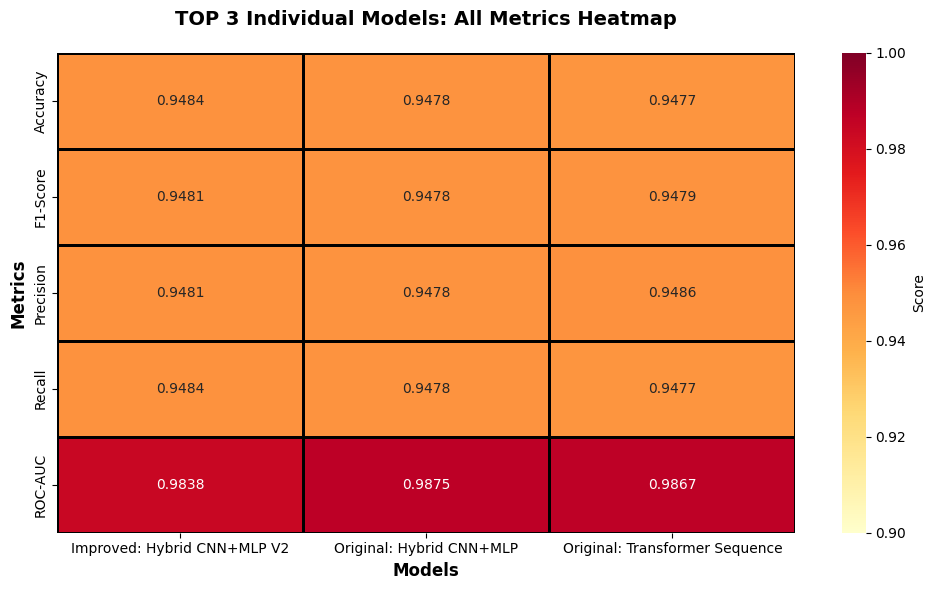

Metrics heatmap saved.


In [54]:
# 4. Heatmap of metrics for TOP 3 individual models
metrics_data = []
for _, row in top3_individual_models.iterrows():
    metrics_data.append({
        'Model': row['model_name'],
        'Accuracy': row['accuracy'],
        'F1-Score': row['f1'],
        'Precision': row['precision'],
        'Recall': row['recall'],
        'ROC-AUC': row['roc_auc']
    })

metrics_df_individual = pd.DataFrame(metrics_data)
metrics_df_individual = metrics_df_individual.set_index('Model')

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(metrics_df_individual.T, annot=True, fmt='.4f', cmap='YlOrRd', 
            cbar_kws={'label': 'Score'}, ax=ax, vmin=0.90, vmax=1.0,
            linewidths=1, linecolor='black')

ax.set_title('TOP 3 Individual Models: All Metrics Heatmap', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Metrics', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'top3_individual_models_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Metrics heatmap saved.")

In [55]:
# 5. Detailed reports for TOP 3 individual models
from sklearn.metrics import classification_report

print("="*80)
print("DETAILED REPORTS FOR TOP 3 MODELS")
print("="*80)

for idx, (_, row) in enumerate(top3_individual_models.iterrows(), 1):
    model_name = row['model_name']
    data = top3_individual_metrics[model_name]
    
    print(f"\n{'='*80}")
    print(f"Model {idx}: {model_name}")
    print(f"{'='*80}")
    print(classification_report(data['labels'], data['predictions'], 
                              target_names=['Class 0', 'Class 1'], digits=4))
    
    print(f"Overall Accuracy: {row['accuracy']:.4f}")
    print(f"ROC-AUC: {row['roc_auc']:.4f}")
    print(f"Weighted F1: {row['f1']:.4f}")
    print(f"Weighted Precision: {row['precision']:.4f}")
    print(f"Weighted Recall: {row['recall']:.4f}")

DETAILED REPORTS FOR TOP 3 MODELS

Model 1: Improved: Hybrid CNN+MLP V2
              precision    recall  f1-score   support

     Class 0     0.9562    0.9706    0.9634      3738
     Class 1     0.9293    0.8970    0.9128      1611

    accuracy                         0.9484      5349
   macro avg     0.9428    0.9338    0.9381      5349
weighted avg     0.9481    0.9484    0.9481      5349

Overall Accuracy: 0.9484
ROC-AUC: 0.9838
Weighted F1: 0.9481
Weighted Precision: 0.9481
Weighted Recall: 0.9484

Model 2: Original: Hybrid CNN+MLP
              precision    recall  f1-score   support

     Class 0     0.9626    0.9628    0.9627      3738
     Class 1     0.9137    0.9131    0.9134      1611

    accuracy                         0.9478      5349
   macro avg     0.9381    0.9380    0.9380      5349
weighted avg     0.9478    0.9478    0.9478      5349

Overall Accuracy: 0.9478
ROC-AUC: 0.9875
Weighted F1: 0.9478
Weighted Precision: 0.9478
Weighted Recall: 0.9478

Model 3: Origi

## Top 3 Ensembles Comparison


In [56]:
# Get TOP 3 ensembles (or all available if less than 3)
top3_ensembles = results_df[results_df['version'] == 'ensemble'].nlargest(3, 'accuracy')

print("="*80)
print("TOP 3 ENSEMBLES")
print("="*80)
for i, (_, row) in enumerate(top3_ensembles.iterrows(), 1):
    print(f"{i}. {row['model_name']}: Acc={row['accuracy']:.4f}, F1={row['f1']:.4f}, ROC-AUC={row['roc_auc']:.4f}")

# Prepare data for visualizations
top3_ensemble_metrics = {}
for _, row in top3_ensembles.iterrows():
    model_name = row['model_name']
    
    if model_name in all_test_metrics:
        top3_ensemble_metrics[model_name] = all_test_metrics[model_name]
    elif 'Ensemble' in model_name:
        # Compute ensemble predictions if not already available
        print(f"\nComputing predictions for {model_name}...")
        
        from models.hybrid.hybrid_cnn_mlp_v2 import HybridCNNMLP_V2
        from models.sequence.transformer_sequence_v2 import TransformerSequence_V2
        from models.specialized.formant_focused_v2 import FormantFocusedModel_V2
        from models.sequence.bilstm_attention_v2 import BiLSTMAttention_V2
        from utils.ensemble_utils import get_model_predictions, weighted_voting, stacking_ensemble
        
        models_list = []
        
        # Load all improved models
        model1 = HybridCNNMLP_V2(n_features=len(feature_cols), num_classes=2).to(device)
        checkpoint1 = torch.load(IMPROVED_DIR / 'hybrid_cnn_mlp_v2' / 'best_model.pt')
        model1.load_state_dict(checkpoint1['model_state_dict'])
        models_list.append((model1, 'Hybrid CNN+MLP V2'))
        
        model2 = TransformerSequence_V2(
            input_dim=128, d_model=256, nhead=8, num_layers=6, 
            dim_feedforward=1024, dropout=0.1, num_classes=2, batch_first=True
        ).to(device)
        checkpoint2 = torch.load(IMPROVED_DIR / 'transformer_sequence_v2' / 'best_model.pt')
        model2.load_state_dict(checkpoint2['model_state_dict'])
        models_list.append((model2, 'Transformer Sequence V2'))
        
        model3 = FormantFocusedModel_V2(n_features=len(feature_cols), num_classes=2).to(device)
        model3.set_formant_indices(feature_cols, ['formant_f1', 'formant_f2', 'formant_f3'])
        checkpoint3 = torch.load(IMPROVED_DIR / 'formant_focused_v2' / 'best_model.pt')
        model3.load_state_dict(checkpoint3['model_state_dict'])
        models_list.append((model3, 'Formant-focused V2'))
        
        model4 = BiLSTMAttention_V2(
            input_dim=128, hidden_dim=128, num_layers=3, 
            num_classes=2, dropout=0.3, num_heads=4
        ).to(device)
        checkpoint4 = torch.load(IMPROVED_DIR / 'bilstm_attention_v2' / 'best_model.pt')
        model4.load_state_dict(checkpoint4['model_state_dict'])
        models_list.append((model4, 'BiLSTM+Attention V2'))
        
        # Get predictions from all models on test set
        test_probs_list = []
        test_labels = None
        
        for model, name in models_list:
            if 'Hybrid' in name:
                loader = dataloaders['hybrid']['test']
            elif 'Transformer' in name or 'BiLSTM' in name:
                loader = dataloaders['sequence']['test']
            else:
                loader = dataloaders['feature']['test']
            
            probs, labels = get_model_predictions([(model, name)], loader, device)
            test_probs_list.append(probs[0])
            if test_labels is None:
                test_labels = labels
        
        # Compute ensemble predictions
        if 'Weighted Voting' in model_name:
            from sklearn.metrics import f1_score
            model_weights = []
            for probs in test_probs_list:
                preds = np.argmax(probs, axis=1)
                f1 = f1_score(test_labels, preds, average='weighted')
                model_weights.append(f1)
            ensemble_probs, ensemble_preds = weighted_voting(test_probs_list, weights=model_weights)
        elif 'Stacking' in model_name:
            val_probs_list = []
            val_labels = None
            
            for model, name in models_list:
                if 'Hybrid' in name:
                    loader = dataloaders['hybrid']['val']
                elif 'Transformer' in name or 'BiLSTM' in name:
                    loader = dataloaders['sequence']['val']
                else:
                    loader = dataloaders['feature']['val']
                
                probs, labels = get_model_predictions([(model, name)], loader, device)
                val_probs_list.append(probs[0])
                if val_labels is None:
                    val_labels = labels
            
            ensemble_preds, ensemble_probs, _ = stacking_ensemble(
                val_probs_list, val_labels,
                val_probs_list, val_labels,
                test_probs_list, test_labels,
                meta_model_type='logistic'
            )
            if len(ensemble_probs.shape) == 1:
                ensemble_probs = np.column_stack([1 - ensemble_probs, ensemble_probs])
        else:
            ensemble_probs, ensemble_preds = weighted_voting(test_probs_list)
        
        # Store metrics
        from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
        
        top3_ensemble_metrics[model_name] = {
            'metrics': {
                'accuracy': accuracy_score(test_labels, ensemble_preds),
                'f1': f1_score(test_labels, ensemble_preds, average='weighted'),
                'roc_auc': roc_auc_score(test_labels, ensemble_probs[:, 1]),
                'precision': precision_score(test_labels, ensemble_preds, average='weighted'),
                'recall': recall_score(test_labels, ensemble_preds, average='weighted')
            },
            'predictions': ensemble_preds,
            'labels': test_labels,
            'probabilities': ensemble_probs
        }
        
        print(f"Predictions for {model_name} computed")

print(f"\nPrepared data for {len(top3_ensemble_metrics)} ensembles")

TOP 3 ENSEMBLES
1. Ensemble: Stacking (Logistic): Acc=0.9549, F1=0.9547, ROC-AUC=0.9878
2. Ensemble: Weighted Voting: Acc=0.9538, F1=0.9537, ROC-AUC=0.9881

Computing predictions for Ensemble: Stacking (Logistic)...


Meta-model validation - Acc: 0.9588, F1: 0.9587
Predictions for Ensemble: Stacking (Logistic) computed

Computing predictions for Ensemble: Weighted Voting...


Predictions for Ensemble: Weighted Voting computed

Prepared data for 2 ensembles


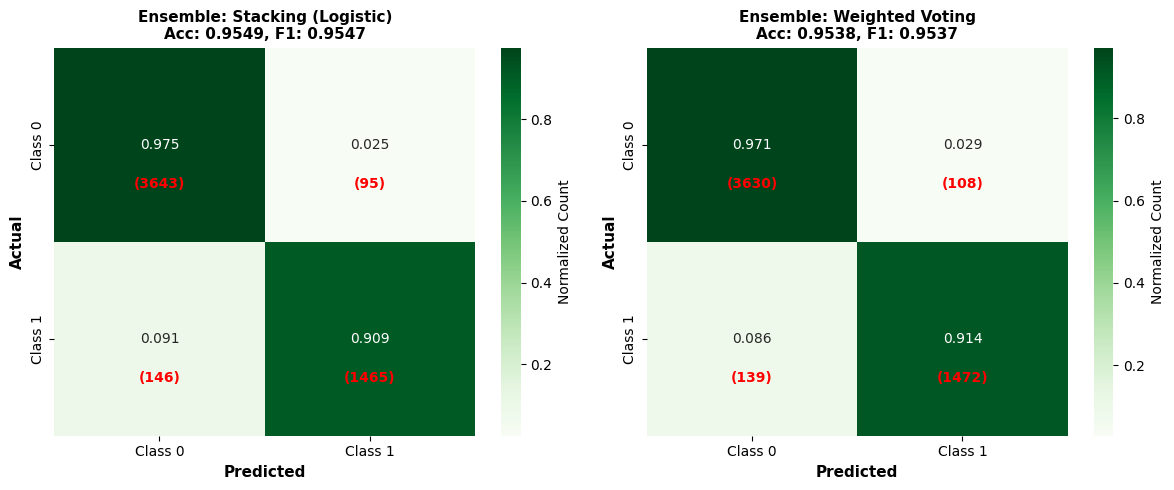

Confusion matrices for TOP 3 ensembles saved.


In [57]:
# 1. Confusion Matrices for TOP 3 ensembles
n_ensembles = len(top3_ensembles)
fig, axes = plt.subplots(1, n_ensembles, figsize=(6*n_ensembles, 5))

if n_ensembles == 1:
    axes = [axes]

for idx, (_, row) in enumerate(top3_ensembles.iterrows()):
    model_name = row['model_name']
    data = top3_ensemble_metrics[model_name]
    
    cm = confusion_matrix(data['labels'], data['predictions'])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    ax = axes[idx]
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Greens', 
                xticklabels=['Class 0', 'Class 1'], 
                yticklabels=['Class 0', 'Class 1'],
                ax=ax, cbar_kws={'label': 'Normalized Count'})
    
    # Add raw counts
    for i in range(2):
        for j in range(2):
            ax.text(j+0.5, i+0.7, f'({cm[i,j]})', 
                   ha='center', va='center', fontsize=10, color='red', fontweight='bold')
    
    ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}\nAcc: {row["accuracy"]:.4f}, F1: {row["f1"]:.4f}', 
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'top3_ensembles_confusion.png', dpi=300, bbox_inches='tight')
plt.show()
print("Confusion matrices for TOP 3 ensembles saved.")

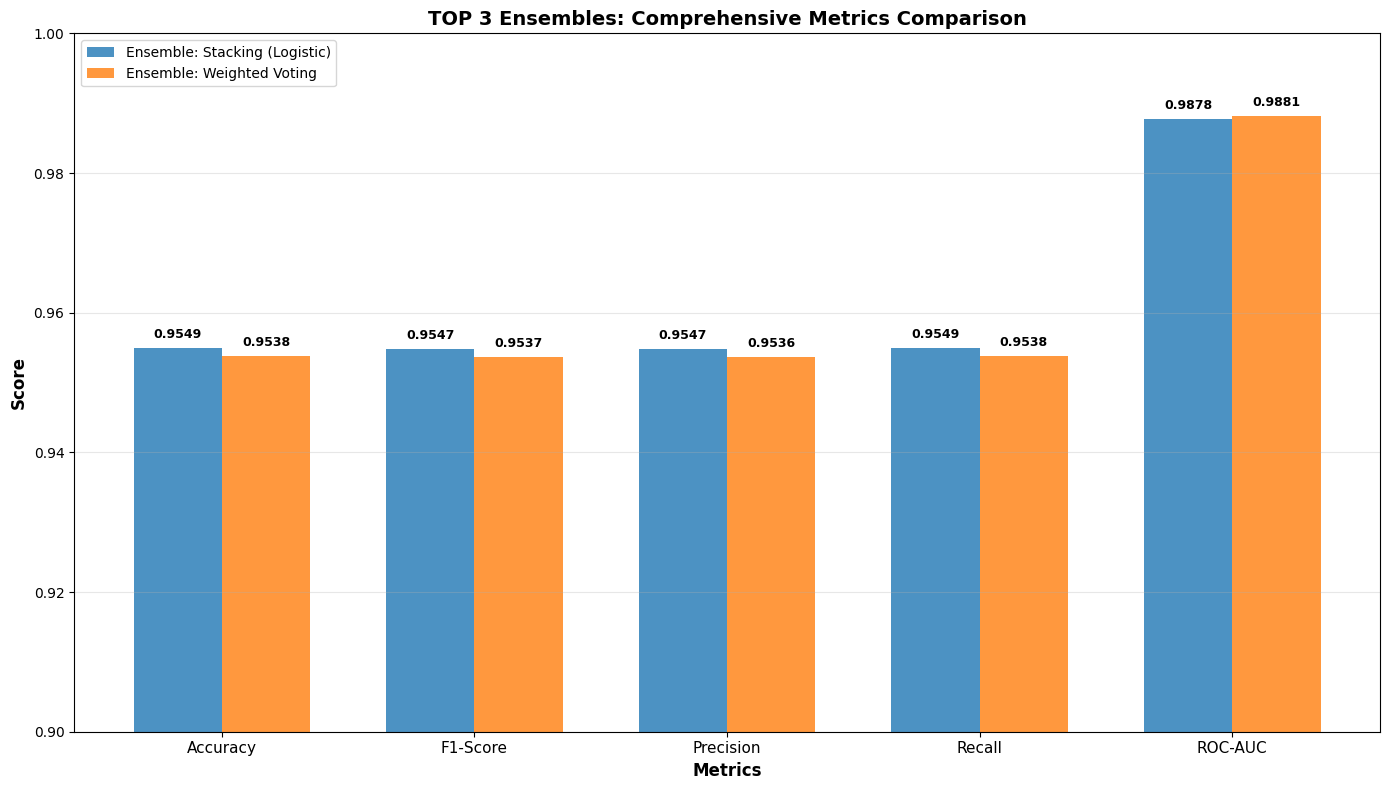

Metrics comparison saved.


In [58]:
# 2. Metrics Comparison for TOP 3 ensembles
metrics_to_compare = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
metric_names = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC-AUC']

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(metrics_to_compare))
width = 0.35 if n_ensembles == 2 else 0.25

for idx, (_, row) in enumerate(top3_ensembles.iterrows()):
    model_name = row['model_name']
    values = [row[metric] for metric in metrics_to_compare]
    
    offset = (idx - (n_ensembles-1)/2) * width
    bars = ax.bar(x + offset, values, width, label=model_name, alpha=0.8)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
               f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('TOP 3 Ensembles: Comprehensive Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metric_names, fontsize=11)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0.90, 1.0])

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'top3_ensembles_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print("Metrics comparison saved.")

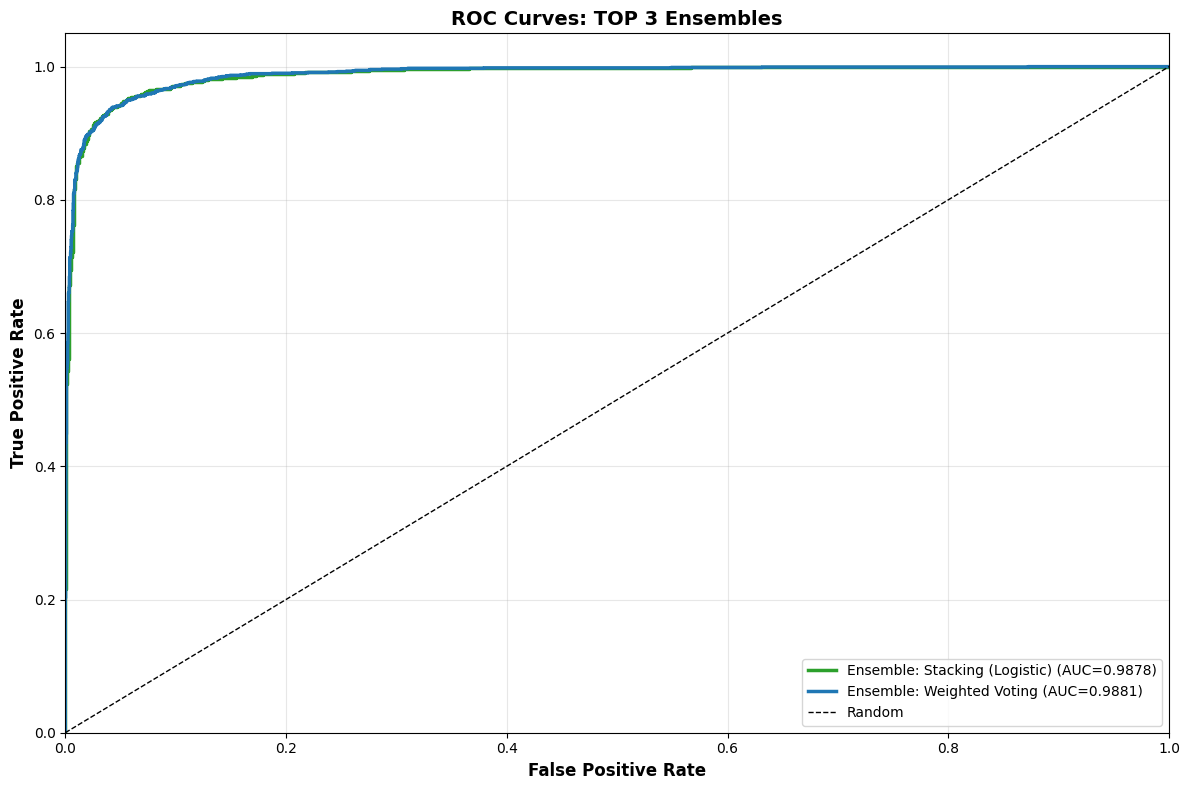

ROC curves saved.


In [59]:
# 3. ROC Curves for TOP 3 ensembles
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#2ca02c', '#1f77b4', '#ff7f0e']

for idx, (_, row) in enumerate(top3_ensembles.iterrows()):
    model_name = row['model_name']
    data = top3_ensemble_metrics[model_name]
    
    fpr, tpr, _ = roc_curve(data['labels'], np.array(data['probabilities'])[:, 1])
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, linewidth=2.5, label=f'{model_name} (AUC={roc_auc:.4f})', 
           color=colors[idx % len(colors)])

ax.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves: TOP 3 Ensembles', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'top3_ensembles_roc.png', dpi=300, bbox_inches='tight')
plt.show()
print("ROC curves saved.")

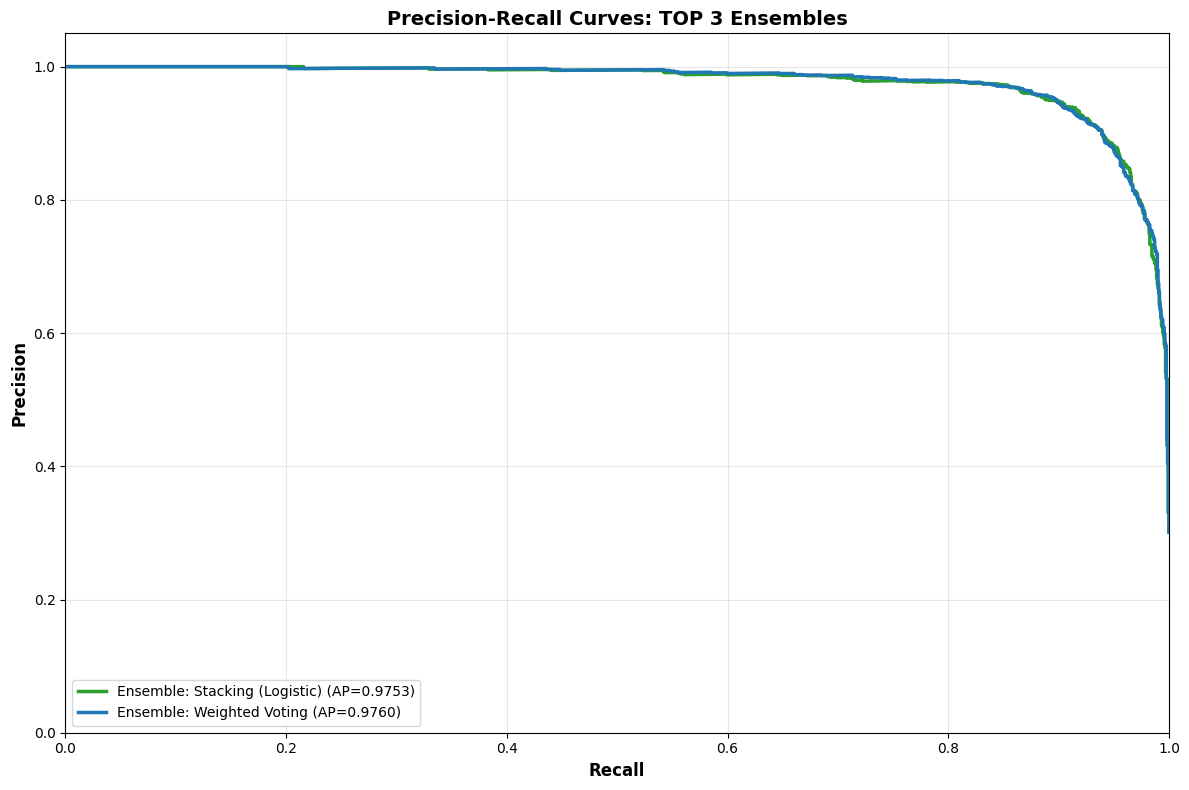

Precision-Recall curves saved.


In [60]:
# 4. Precision-Recall Curves for TOP 3 ensembles
from sklearn.metrics import precision_recall_curve, average_precision_score

fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#2ca02c', '#1f77b4', '#ff7f0e']

for idx, (_, row) in enumerate(top3_ensembles.iterrows()):
    model_name = row['model_name']
    data = top3_ensemble_metrics[model_name]
    
    labels = np.array(data['labels'])
    probs = np.array(data['probabilities'])
    
    if len(probs.shape) == 1:
        probs_class1 = probs
    else:
        probs_class1 = probs[:, 1] if probs.shape[1] > 1 else probs[:, 0]
    
    precision, recall, _ = precision_recall_curve(labels, probs_class1)
    ap_score = average_precision_score(labels, probs_class1)
    
    ax.plot(recall, precision, linewidth=2.5, label=f'{model_name} (AP={ap_score:.4f})', 
           color=colors[idx % len(colors)])

ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curves: TOP 3 Ensembles', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'top3_ensembles_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("Precision-Recall curves saved.")

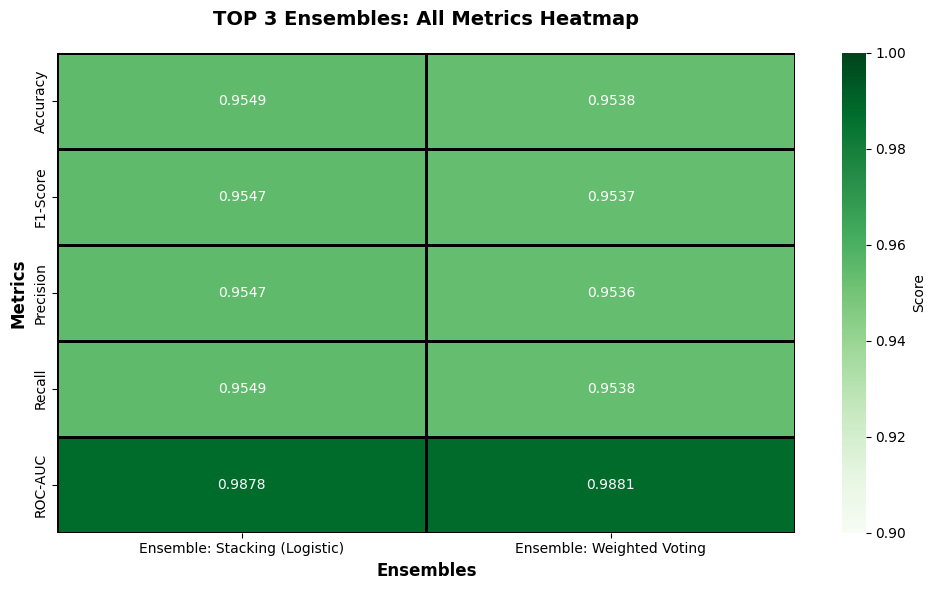

Metrics heatmap saved.


In [61]:
# 5. Heatmap of metrics for TOP 3 ensembles
metrics_data = []
for _, row in top3_ensembles.iterrows():
    metrics_data.append({
        'Ensemble': row['model_name'],
        'Accuracy': row['accuracy'],
        'F1-Score': row['f1'],
        'Precision': row['precision'],
        'Recall': row['recall'],
        'ROC-AUC': row['roc_auc']
    })

metrics_df_ensemble = pd.DataFrame(metrics_data)
metrics_df_ensemble = metrics_df_ensemble.set_index('Ensemble')

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(metrics_df_ensemble.T, annot=True, fmt='.4f', cmap='Greens', 
            cbar_kws={'label': 'Score'}, ax=ax, vmin=0.90, vmax=1.0,
            linewidths=1, linecolor='black')

ax.set_title('TOP 3 Ensembles: All Metrics Heatmap', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Ensembles', fontsize=12, fontweight='bold')
ax.set_ylabel('Metrics', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'top3_ensembles_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Metrics heatmap saved.")

In [62]:
# 6. Detailed reports for TOP 3 ensembles
print("="*80)
print("DETAILED REPORTS FOR TOP 3 ENSEMBLES")
print("="*80)

for idx, (_, row) in enumerate(top3_ensembles.iterrows(), 1):
    model_name = row['model_name']
    data = top3_ensemble_metrics[model_name]
    
    print(f"\n{'='*80}")
    print(f"Ensemble {idx}: {model_name}")
    print(f"{'='*80}")
    print(classification_report(data['labels'], data['predictions'], 
                              target_names=['Class 0', 'Class 1'], digits=4))
    
    print(f"Overall Accuracy: {row['accuracy']:.4f}")
    print(f"ROC-AUC: {row['roc_auc']:.4f}")
    print(f"Weighted F1: {row['f1']:.4f}")
    print(f"Weighted Precision: {row['precision']:.4f}")
    print(f"Weighted Recall: {row['recall']:.4f}")

DETAILED REPORTS FOR TOP 3 ENSEMBLES

Ensemble 1: Ensemble: Stacking (Logistic)
              precision    recall  f1-score   support

     Class 0     0.9615    0.9746    0.9680      3738
     Class 1     0.9391    0.9094    0.9240      1611

    accuracy                         0.9549      5349
   macro avg     0.9503    0.9420    0.9460      5349
weighted avg     0.9547    0.9549    0.9547      5349

Overall Accuracy: 0.9549
ROC-AUC: 0.9878
Weighted F1: 0.9547
Weighted Precision: 0.9547
Weighted Recall: 0.9549

Ensemble 2: Ensemble: Weighted Voting
              precision    recall  f1-score   support

     Class 0     0.9631    0.9711    0.9671      3738
     Class 1     0.9316    0.9137    0.9226      1611

    accuracy                         0.9538      5349
   macro avg     0.9474    0.9424    0.9448      5349
weighted avg     0.9536    0.9538    0.9537      5349

Overall Accuracy: 0.9538
ROC-AUC: 0.9881
Weighted F1: 0.9537
Weighted Precision: 0.9536
Weighted Recall: 0.9538


COMPARISON OF BEST ENSEMBLE WITH BEST MODEL

Best ensemble: Ensemble: Stacking (Logistic)
  Accuracy: 0.9549
  F1-Score: 0.9547
  ROC-AUC: 0.9878

Best model: Improved: Hybrid CNN+MLP V2
  Accuracy: 0.9484
  F1-Score: 0.9481
  ROC-AUC: 0.9838

Ensemble improvement:
  Accuracy: +0.0065 (0.69%)
  F1-Score: +0.0066 (0.70%)
  ROC-AUC: +0.0039 (0.40%)


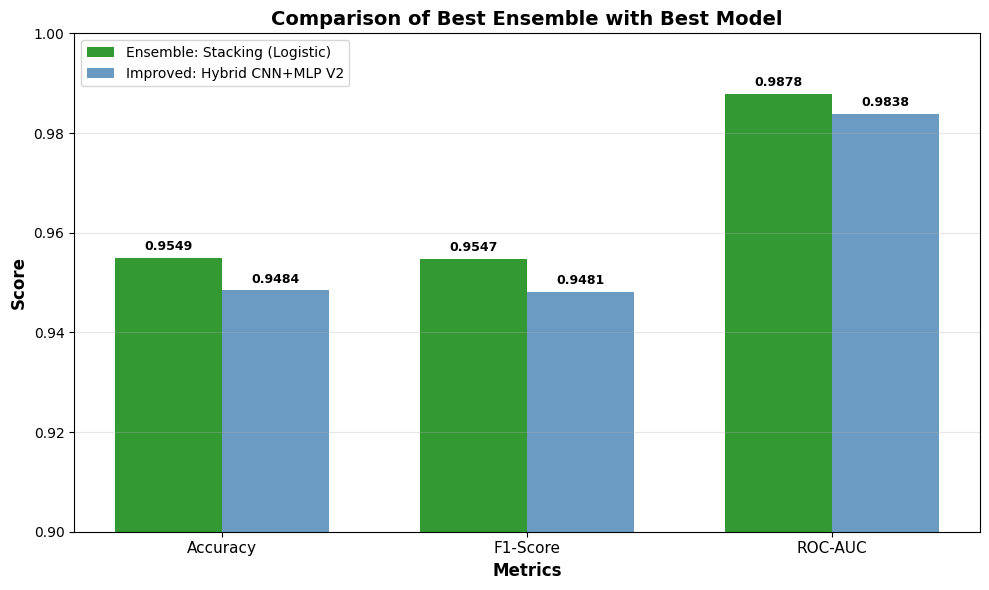


Comparison visualization saved.


In [63]:
# 7. Comparison of best ensemble with best model
print("="*80)
print("COMPARISON OF BEST ENSEMBLE WITH BEST MODEL")
print("="*80)

best_ensemble = top3_ensembles.iloc[0]
best_model = top3_individual_models.iloc[0]

print(f"\nBest ensemble: {best_ensemble['model_name']}")
print(f"  Accuracy: {best_ensemble['accuracy']:.4f}")
print(f"  F1-Score: {best_ensemble['f1']:.4f}")
print(f"  ROC-AUC: {best_ensemble['roc_auc']:.4f}")

print(f"\nBest model: {best_model['model_name']}")
print(f"  Accuracy: {best_model['accuracy']:.4f}")
print(f"  F1-Score: {best_model['f1']:.4f}")
print(f"  ROC-AUC: {best_model['roc_auc']:.4f}")

improvement_acc = best_ensemble['accuracy'] - best_model['accuracy']
improvement_f1 = best_ensemble['f1'] - best_model['f1']
improvement_auc = best_ensemble['roc_auc'] - best_model['roc_auc']

print(f"\nEnsemble improvement:")
print(f"  Accuracy: +{improvement_acc:.4f} ({100*improvement_acc/best_model['accuracy']:.2f}%)")
print(f"  F1-Score: +{improvement_f1:.4f} ({100*improvement_f1/best_model['f1']:.2f}%)")
print(f"  ROC-AUC: +{improvement_auc:.4f} ({100*improvement_auc/best_model['roc_auc']:.2f}%)")

# Visualization comparison
fig, ax = plt.subplots(figsize=(10, 6))

models_compare = [best_ensemble['model_name'], best_model['model_name']]
metrics_compare = ['accuracy', 'f1', 'roc_auc']
metric_names_compare = ['Accuracy', 'F1-Score', 'ROC-AUC']

x = np.arange(len(metrics_compare))
width = 0.35

values_ensemble = [best_ensemble[m] for m in metrics_compare]
values_model = [best_model[m] for m in metrics_compare]

bars1 = ax.bar(x - width/2, values_ensemble, width, label=best_ensemble['model_name'], 
               alpha=0.8, color='green')
bars2 = ax.bar(x + width/2, values_model, width, label=best_model['model_name'], 
               alpha=0.8, color='steelblue')

# Add values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
               f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comparison of Best Ensemble with Best Model', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metric_names_compare, fontsize=11)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0.90, 1.0])

plt.tight_layout()
plt.savefig(COMPARISON_DIR / 'best_ensemble_vs_best_model.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nComparison visualization saved.")

In [64]:
# Final summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nAll visualizations saved to: {COMPARISON_DIR}")
print("\nTOP 3 Models (without ensembles):")
print("  1. top3_individual_models_confusion.png - Confusion matrices")
print("  2. top3_individual_models_metrics.png - Metrics comparison")
print("  3. top3_individual_models_roc.png - ROC curves")
print("  4. top3_individual_models_heatmap.png - Metrics heatmap")
print("\nTOP 3 Ensembles:")
print("  1. top3_ensembles_confusion.png - Confusion matrices")
print("  2. top3_ensembles_metrics.png - Metrics comparison")
print("  3. top3_ensembles_roc.png - ROC curves")
print("  4. top3_ensembles_pr_curves.png - Precision-Recall curves")
print("  5. top3_ensembles_heatmap.png - Metrics heatmap")
print("\nComparison:")
print("  1. best_ensemble_vs_best_model.png - Best ensemble vs best model")
print("\n" + "="*80)


FINAL SUMMARY

All visualizations saved to: /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dl_models/improved_models/comparison

TOP 3 Models (without ensembles):
  1. top3_individual_models_confusion.png - Confusion matrices
  2. top3_individual_models_metrics.png - Metrics comparison
  3. top3_individual_models_roc.png - ROC curves
  4. top3_individual_models_heatmap.png - Metrics heatmap

TOP 3 Ensembles:
  1. top3_ensembles_confusion.png - Confusion matrices
  2. top3_ensembles_metrics.png - Metrics comparison
  3. top3_ensembles_roc.png - ROC curves
  4. top3_ensembles_pr_curves.png - Precision-Recall curves
  5. top3_ensembles_heatmap.png - Metrics heatmap

Comparison:
  1. best_ensemble_vs_best_model.png - Best ensemble vs best model

